# Introduction

Twitter is one of the most widely used social media. It also has become an important communication channel in times of emergency. In this project (Kaggle competition), we are challenged to build a machine learning model that predicts which Tweets are about real disasters and which ones are not. We have access to a dataset of 10,000 tweets that were hand classified.

The objective of this project is to figure out that can CNN models with transfer learning method perform well in the traditional NLP task and how well they could be compared to the "state-of-art" BERT Models. 

	


In [1]:
# import libraries
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
import tensorflow_hub as hub

from wordcloud import WordCloud,STOPWORDS


In [ ]:
# load train and test datasets
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
# check the no. of rows and columns in the dataset
train.shape, test.shape

((7613, 5), (3263, 4))

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
id             0
text           0
target         0
dtype: int64

In [ ]:
test.isnull().sum().sort_values(ascending = False)

location    1105
keyword       26
id             0
text           0
dtype: int64

We can see there are a lot of null values for "keyword" and "location" columns in both training set and testing set. 

# Exploratory Data Analysis

First, let's check the distribution of these two classes (real & fake). From the plot below we can see that the training set is nearly balanced. Since this dataset is not too large, therefore, we did not apply any dataset balancing technique to this training set in order to avoid overfitting.

In [ ]:
# check class distribution

print("No. of Real Disaster Tweets (Target = 1):",len(train[train["target"]==1]))
print("No. of Fake Disaster Tweets (Target = 0):",len(train[train["target"]==0]))

No. of Real Disaster Tweets (Target = 1): 3271
No. of Fake Disaster Tweets (Target = 0): 4342


<ipython-input-11-d27759a14032>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(["Real","Fake"], [len(train[train.target==1]), len(train[train.target==0])],color = 'grbkymc')


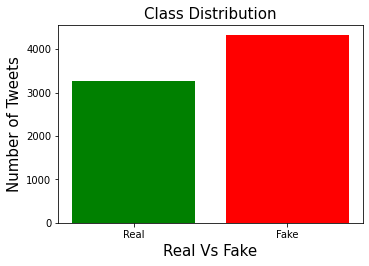

In [ ]:
# lets visualize the class distribution

plt.figure(figsize = (12,8))
plt.subplot(2,2,1)
plt.bar(["Real","Fake"], [len(train[train.target==1]), len(train[train.target==0])],color = 'grbkymc')
plt.xlabel("Real Vs Fake", fontsize=15)
plt.ylabel("Number of Tweets", fontsize=15)
plt.title("Class Distribution", fontsize=15)
plt.show()

Then we will check the text length in both classes. From the output below we can see that the distributions of text length of tweets (real & fake) have the similar range (approximately 0-150) and the similar left-skewed distribution.  


In [ ]:
# we will now check the length of "real disaster" vs lenght of "fake disaster" tweets
# lets first add a new field to the dataset called "length"
def length(text):    
    return len(text)

train["length"]= train.text.apply(length)

# lets check the average lenght of real vs fake tweets
print(train.groupby("target").mean()["length"].sort_values(ascending = False))


target
1    108.113421
0     95.706817
Name: length, dtype: float64


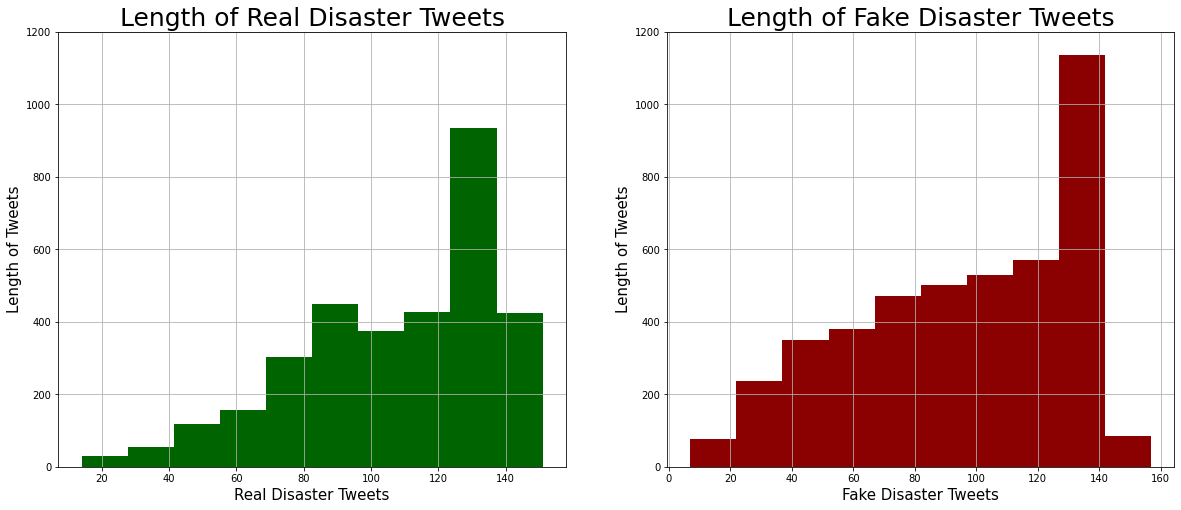

In [ ]:
# lets see the distribution of length of tweets real vs fake
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.hist(train[train.target==1]["length"],color = "darkgreen")
plt.title("Length of Real Disaster Tweets",fontsize=25)
plt.xlabel("Real Disaster Tweets",fontsize=15)
plt.ylabel("Length of Tweets",fontsize=15)
plt.ylim(0,1200)
plt.grid()


plt.subplot(1,2,2)
plt.hist(train[train.target==0]["length"],color = "darkred")
plt.title("Length of Fake Disaster Tweets",fontsize=25)
plt.xlabel("Fake Disaster Tweets",fontsize=15)
plt.ylabel("Length of Tweets",fontsize=15)
plt.ylim(0,1200)
plt.grid()


We also looked at the average text length for both real and fake classes. From the plot below we can see that the average lengths are almost the same for both classes. Therefore, we can safely say that the text length is not important when determining whether the tweet is real or fake. 

<ipython-input-14-6fd54b59b37d>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(["Real","Fake"], [train[train.target==1].mean()["length"], train[train.target==0].mean()["length"]],color = 'grbkymc')
<ipython-input-14-6fd54b59b37d>:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(["Real","Fake"], [train[train.target==1].mean()["length"], train[train.target==0].mean()["length"]],color = 'grbkymc')


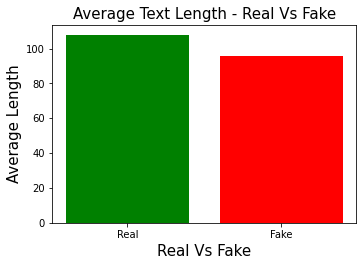

In [ ]:
# lets visualize the class distribution
plt.figure(figsize = (12,8))
plt.subplot(2,2,1)
plt.bar(["Real","Fake"], [train[train.target==1].mean()["length"], train[train.target==0].mean()["length"]],color = 'grbkymc')
plt.xlabel("Real Vs Fake", fontsize=15)
plt.ylabel("Average Length", fontsize=15)
plt.title("Average Text Length - Real Vs Fake", fontsize=15)
plt.show()

In [ ]:
# lets drop the column
train.drop("length",1,inplace=True)

<ipython-input-15-1b944c7bcc94>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train.drop("length",1,inplace=True)


# Stopwords & Punctuations

1. "stopwords" usually refers to the most common words in a language. For example 'a', 'the', 'in' etc. These words are essential parts of any language but do not play any significant role to the meaning of a sentence.

2. Punctuation marks are marks such as a full stop, comma, or question mark, used in writing to separate sentences and their elements and to clarify meaning.
(!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~)

In [ ]:
#lets save stopwords in a variable
nltk.download('stopwords')
stop = stopwords.words("english")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)

### Stopwords in the whole dataset (train & test)

First, let us look at the frequency of stopwords that appear in the whole dataset (train + test). We made list of all stopwords and converted this list to a frequency dictionary to make frequency barplots. 

In [ ]:
# stopwords present in the whole dataset
sw = []
for message in train.text:
    for word in message.split():
        if word in stop:
            sw.append(word)


# lets convert the list to a dictinoary which would contain the stop words and their frequency
stopwordlist = nltk.FreqDist(sw)
# lets save the 10 most frequent stopwords
top10sw = stopwordlist.most_common(10)
top10sw_ziplist = list(zip(*top10sw))

<ipython-input-19-9f8cef58ee01>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(top10sw_ziplist[0],top10sw_ziplist[1],color='grbkymc')


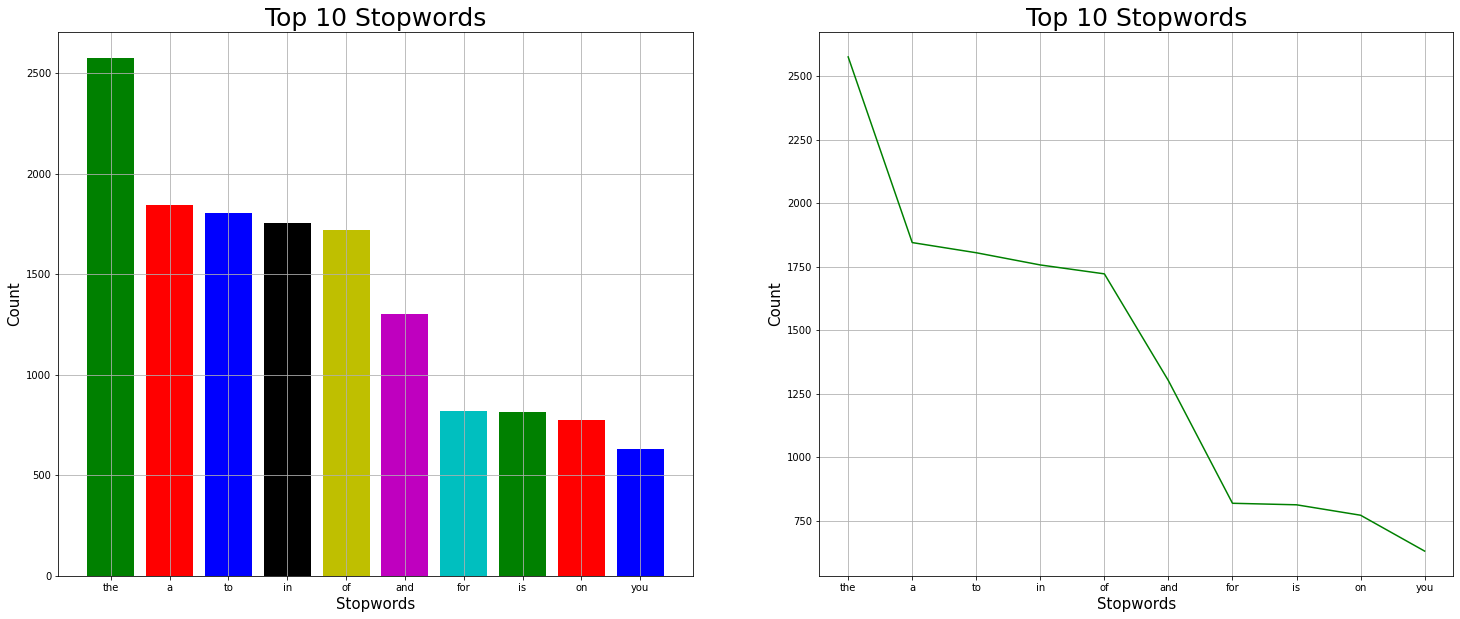

In [ ]:
# Graphs for top 10 stopwords present in all the tweets

plt.figure(figsize = (25,10))
plt.subplot(1,2,1)
plt.bar(top10sw_ziplist[0],top10sw_ziplist[1],color='grbkymc')
plt.title("Top 10 Stopwords",fontsize=25)
plt.xlabel("Stopwords",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.grid()

plt.subplot(1,2,2)
plt.plot(top10sw_ziplist[0],top10sw_ziplist[1],'g')
plt.title("Top 10 Stopwords",fontsize=25)
plt.xlabel("Stopwords",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.grid()

From the figures above, we plotted the most frequent 10 stopwords with their appearing frequency. We can see that 9 out of 10 most frequent stopwords are preposition words, which do not have too much meaning. 

### Punctuations in the whole dataset (train & test)

Similarly to what we did above, we recorded the frequencies of puncation marks in the whole dataset and visualize them in barplot.

In [ ]:
# punctuations present in all the tweets 
pun = []
for message in train.text:
    for word in message.split():
        if word in punctuation:
            pun.append(word)


# lets convert the list to a dictinoary which would contain the punctuations and their frequency
wordlist = nltk.FreqDist(pun)
# lets save the 10 most frequent stopwords
top10pun = wordlist.most_common(10)
top10pun_ziplist = list(zip(*top10pun))

<ipython-input-21-ee1a6f91c9c9>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(top10pun_ziplist[0],top10pun_ziplist[1],color='grbkymc')


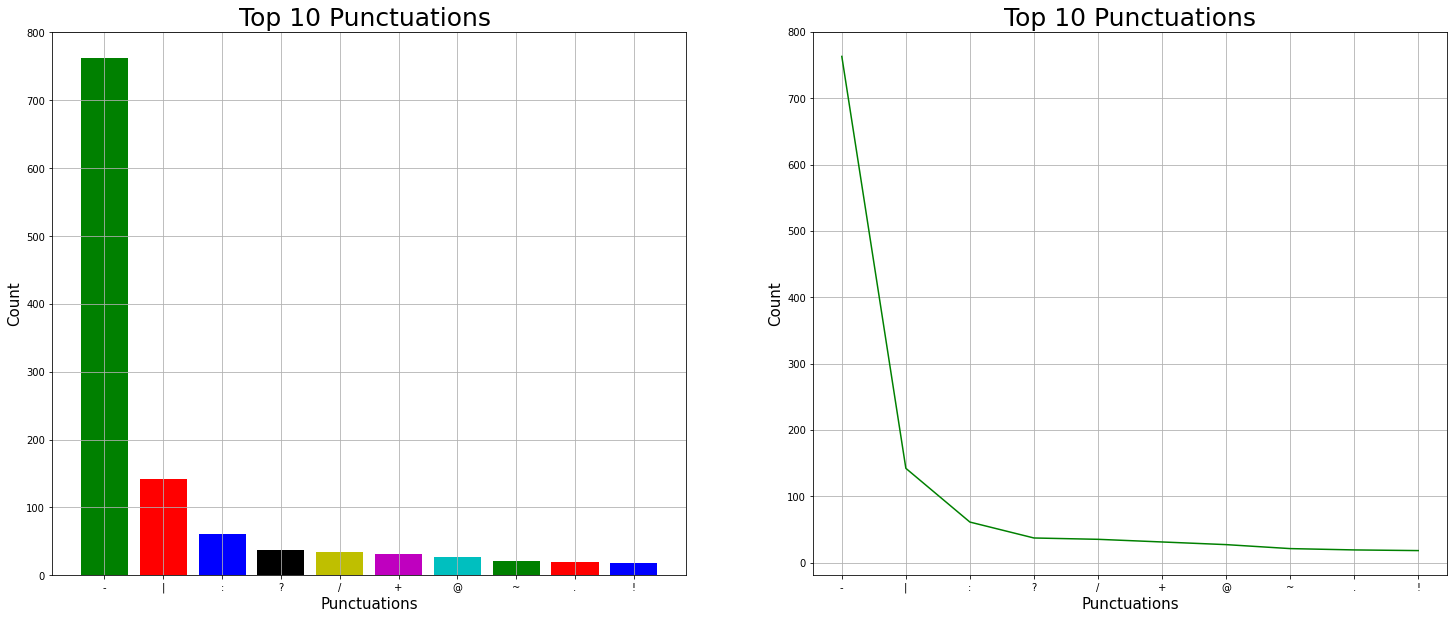

In [ ]:
# draw graphs for top10 Punctuations

plt.figure(figsize = (25,10))
plt.subplot(1,2,1)
plt.bar(top10pun_ziplist[0],top10pun_ziplist[1],color='grbkymc')
plt.title("Top 10 Punctuations ",fontsize=25)
plt.xlabel("Punctuations",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.grid()

plt.subplot(1,2,2)
plt.plot(top10pun_ziplist[0],top10pun_ziplist[1],'g')
plt.title("Top 10 Punctuations",fontsize=25)
plt.xlabel("Punctuations",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.grid()

From the figures above, we also plotted the top 10 popular punctuation marks with their frequencies. We can see that the frequency differs a lot, and the most popular one is '-'(dash) which appears about 600 more times than the second most popular punctuation mark. 

### Stopwords & Punctuations in real v.s. fake tweets separately

In this section, we will look at the stopwords and punctuation marks in the real tweets and fake tweets separately so that we can figure out if the stopwords and punctuation marks have the significant influence when making the classifications. 

We applied the same method as we did in previous parts to plot the most popular stopwords and punctuations, and plot them horizontally so that we can compare the outcome from both class together. 

In [ ]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_real = []
pun_real  = []
for message in train[train.target==1]["text"]:
    for word in message.split():
        if word in stop:
            stop_real.append(word)
        if word in punctuation:
            pun_real.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_real_wordlist = nltk.FreqDist(stop_real)
pun_real_wordlist =  nltk.FreqDist(pun_real)

# lets save the 10 most frequent stopwords
stop_real_top10 = stop_real_wordlist.most_common(10)
pun_real_top10  = pun_real_wordlist.most_common(10)

In [ ]:
# Let's check "Fake Disaster Tweets" and create a list of stop words and punctuations
stop_fake = []
pun_fake  = []
for message in train[train.target==0]["text"]:
    for word in message.split():
        if word in stop:
            stop_fake.append(word)
        if word in punctuation:
            pun_fake.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_fake_wordlist = nltk.FreqDist(stop_fake)
pun_fake_wordlist =  nltk.FreqDist(pun_fake)

# lets save the 10 most frequent stopwords
stop_fake_top10 = stop_fake_wordlist.most_common(10)
pun_fake_top10  = pun_fake_wordlist.most_common(10)

<ipython-input-24-1b92d0e14025>:11: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(x_stop_real, y_stop_real,color = 'grbkymc')
<ipython-input-24-1b92d0e14025>:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(x_stop_fake, y_stop_fake,color = 'grbkymc')
<ipython-input-24-1b92d0e14025>:23: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(x_pun_real, y_pun_real,color = 'grbkymc')
<ipython-input-24-1b92d0e14025>:29: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(x_pun_fake, y_pun_fake,color = 'grbkymc')


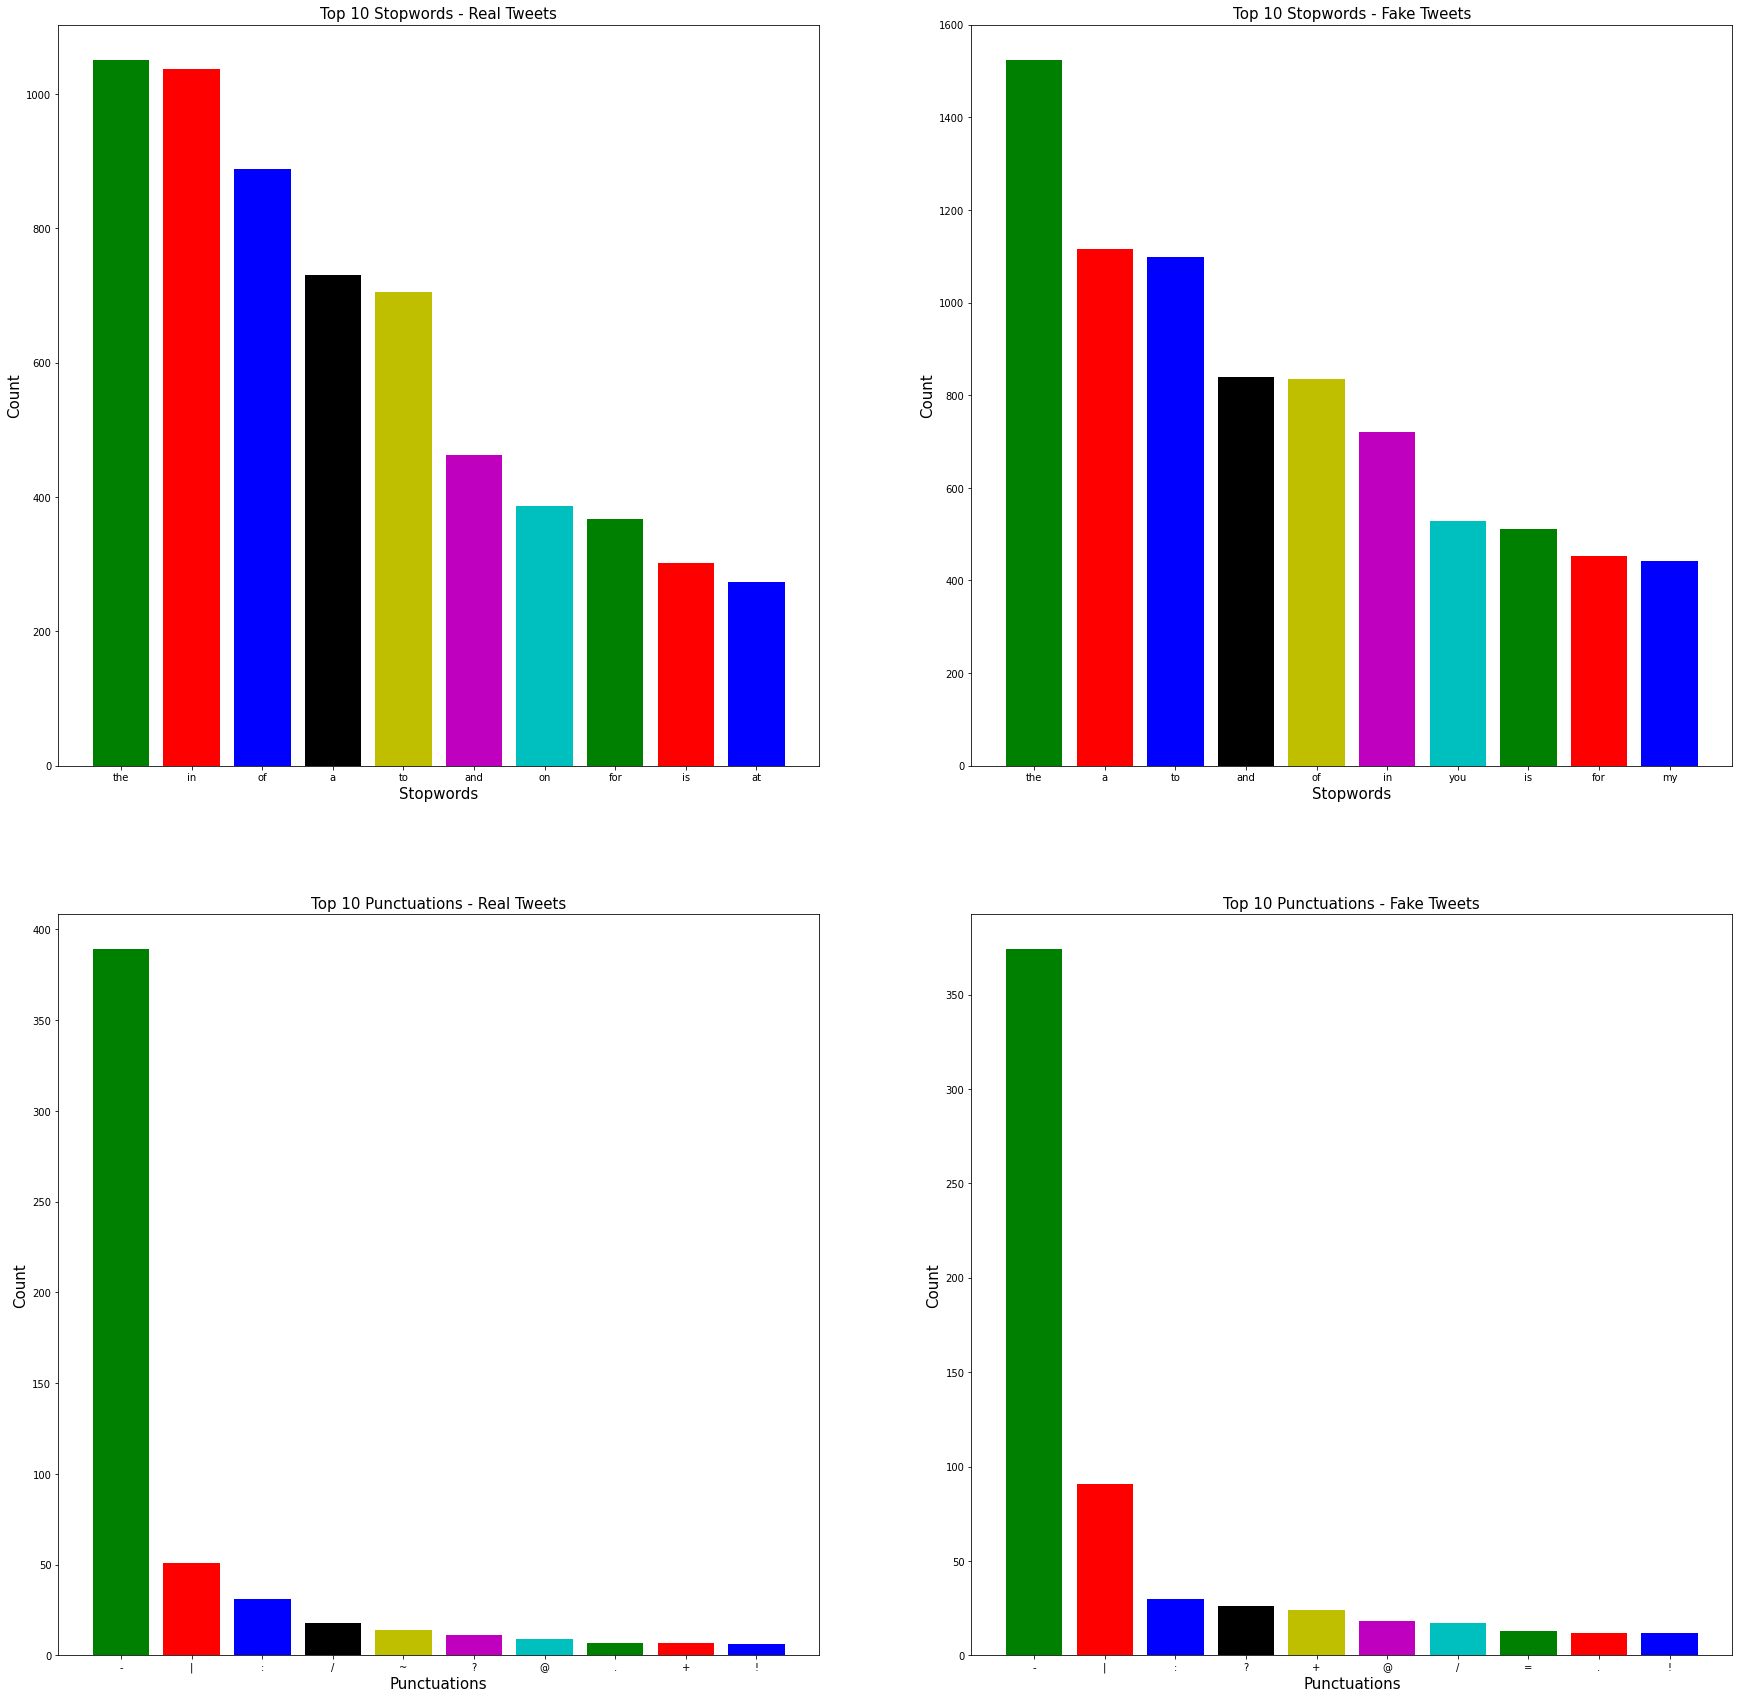

In [ ]:
x_stop_real,y_stop_real=zip(*stop_real_top10)
x_pun_real, y_pun_real =zip(*pun_real_top10)

x_stop_fake,y_stop_fake=zip(*stop_fake_top10)
x_pun_fake, y_pun_fake=zip(*pun_fake_top10)


plt.figure(figsize = (30,30))

plt.subplot(2,2,1)
plt.bar(x_stop_real, y_stop_real,color = 'grbkymc')
plt.xlabel("Stopwords", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Top 10 Stopwords - Real Tweets", fontsize=15)

plt.subplot(2,2,2)
plt.bar(x_stop_fake, y_stop_fake,color = 'grbkymc')
plt.xlabel("Stopwords", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Top 10 Stopwords - Fake Tweets", fontsize=15)

plt.subplot(2,2,3)
plt.bar(x_pun_real, y_pun_real,color = 'grbkymc')
plt.xlabel("Punctuations", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Top 10 Punctuations - Real Tweets", fontsize=15)

plt.subplot(2,2,4)
plt.bar(x_pun_fake, y_pun_fake,color = 'grbkymc')
plt.xlabel("Punctuations", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Top 10 Punctuations - Fake Tweets", fontsize=15)

plt.show()




From the figures above, we can see that most top 10 stopwords and punctuations are the same for both classes since there are so few different words/marks coming from these 2 classes. Therefore, we can safely state that stopwords/punctuations have no strong relation between with real/fake disaster tweets.

# Data Cleaning

We did some data cleaning procedures in order to get more accurate results from the machine learning models. 

The first step we made is removing all hyperlinks & URLs since these links has no meaning themselves. 

And then we remove all embedded special characters in tweets such as hushtags like #earthquake. 

Next, we remove all numerical characters in tweets and this step will delete all numbers in the tweets because we think that numbers themselves have no significant influence when classifying if the tweet is real or not.

Also, we remove all user IDs appeared in tweets since it is similar to the hushtags. 

Then we convert all letters to lower case so that words like "Go" & "go" can be treated as same word and not different words. 

The second last step in data cleaning is to remove stopwords and punctuations which are usually not important in understanding the meaning of the whole tweet, and convert words to their lemmas(for example, the lemma of word "flying" would be "fly") to improve the predictive power of our model.

Finally, we remove all emoji at the end of data cleaning procedures. 

In [ ]:
# create an object to convert the words to its lemma form
nltk.download('wordnet')
nltk.download('omw-1.4')
lemma = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# lets make a combine list of stopwords and punctuations
sw_pun = stop + punctuation

In [ ]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = re.sub("([@][A-Za-z0-9_]+)|(\w+:\/\/\S+)","", tweet) #remove @user_id
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [ ]:
# apply preprocessing functions on the train and test datasets
train['text'] = train['text'].apply(lambda s : preprocess(s))
test['text'] = test['text'].apply(lambda s : preprocess(s))

In [ ]:
# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test['text'] = test['text'].apply(lambda s : remove_emoji(s))


# Vocabulary creation & N-gram Analysis


After we cleaned the whole dataset, we want to know if the content of real tweets will be different compared to the content of fake tweets, and if so, how it differs. Therefore, before we build any machine learning models, we create the vocabulary for this dataset and conduct the N-gram Analysis to have a better overall picture of our dataset. 

### Vocabulary

First, we create a vocabulary to include all unique words. From the output below we can see that there are 16442 distinct words in the training set(after preprocessing). And also we printed the most common 50 words.

In [ ]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)



In [ ]:
# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

16442

In [ ]:
# lets check the most common 50 words in the vocabulary
vocab.most_common(50)


[('like', 560),
 ('fire', 534),
 ('bomb', 338),
 ('news', 299),
 ('people', 286),
 ('burn', 262),
 ('time', 254),
 ('kill', 253),
 ('make', 248),
 ('attack', 240),
 ('flood', 233),
 ('crash', 232),
 ('build', 231),
 ('emergency', 229),
 ('video', 228),
 ('come', 223),
 ('disaster', 220),
 ('take', 217),
 ('would', 214),
 ('body', 209),
 ('think', 204),
 ('police', 199),
 ('look', 193),
 ('know', 192),
 ('love', 190),
 ('watch', 188),
 ('home', 187),
 ('storm', 187),
 ('still', 181),
 ('train', 177),
 ('suicide', 177),
 ('live', 172),
 ('first', 170),
 ('collapse', 169),
 ('back', 164),
 ('scream', 164),
 ('california', 159),
 ('want', 156),
 ('drown', 152),
 ('cause', 151),
 ('need', 150),
 ('work', 149),
 ('today', 149),
 ('world', 148),
 ('nuclear', 148),
 ('hiroshima', 147),
 ('year', 143),
 ('full', 143),
 ('service', 142),
 ('destroy', 138)]

Then, we want to see how many words have appeared more than once in the corpus so that we could know the proportion of "rare" words. After we create another vocabulary to include the words with more than 1 occurence, we can see that there are 6025 words appear more than once in the training set, and the remaining ~10000 words appear only once. 

In [ ]:
# words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [ ]:
# lets check the no. of the words with more than one occurence
len(final_vocab)


6025

### N-gram Analysis

Now we can move to N-gram Analysis. An n-gram is basically a collection of n successive items in a text document. 

For example, I want to let the machine determine whether "I love eating burgers" is a real disaster or not. 

Unigrams(1-gram) consider words one by one so the machine will get "I", "love", "eating" and "burgers".

Bigrams(2-gram) will consider phrases with 2 words so the machine will get "I love", "love eating" and "eating burgers".

Trigrams(3-gram) will similarly consider phrases with 3 words such as "I love eating", "love eating burgers". 

So, in this way, by conducting and comparing the n-gram analysis from these 2 classes, will give us a better understanding about how contents differ between these two classes.  

In [ ]:
# lets create seperate datasets from real and fake tweets
real = train[train.target==1].reset_index()
fake = train[train.target==0].reset_index()

In [ ]:
# function to create top 100 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["text"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [ ]:
# function to visualize the top 100 n-grams in real and fake disaster tweets
def draw_barplots(real,fake,title):
    plt.figure(figsize = (40,80),dpi=100)

    plt.subplot(1,2,1)
    sns.barplot(y=real[0].values[:100], x=real[1].values[:100], color='green')
    plt.title("Top 100" + title + "in Real Tweets",fontsize=15)
    
    plt.subplot(1,2,2)
    sns.barplot(y=fake[0].values[:100], x=fake[1].values[:100],color='red')
    plt.title("Top 100" + title + "in Fake Tweets",fontsize=15)

#### Unigrams

Real: fire,bomb,kill,news,flood,disaster,crash…

Fake: like,make,body,love,come,time,think…

In [ ]:
# lets create top 100 unigrams
real_unigrams = get_ngrams(real,1)
fake_unigrams = get_ngrams(fake,1)

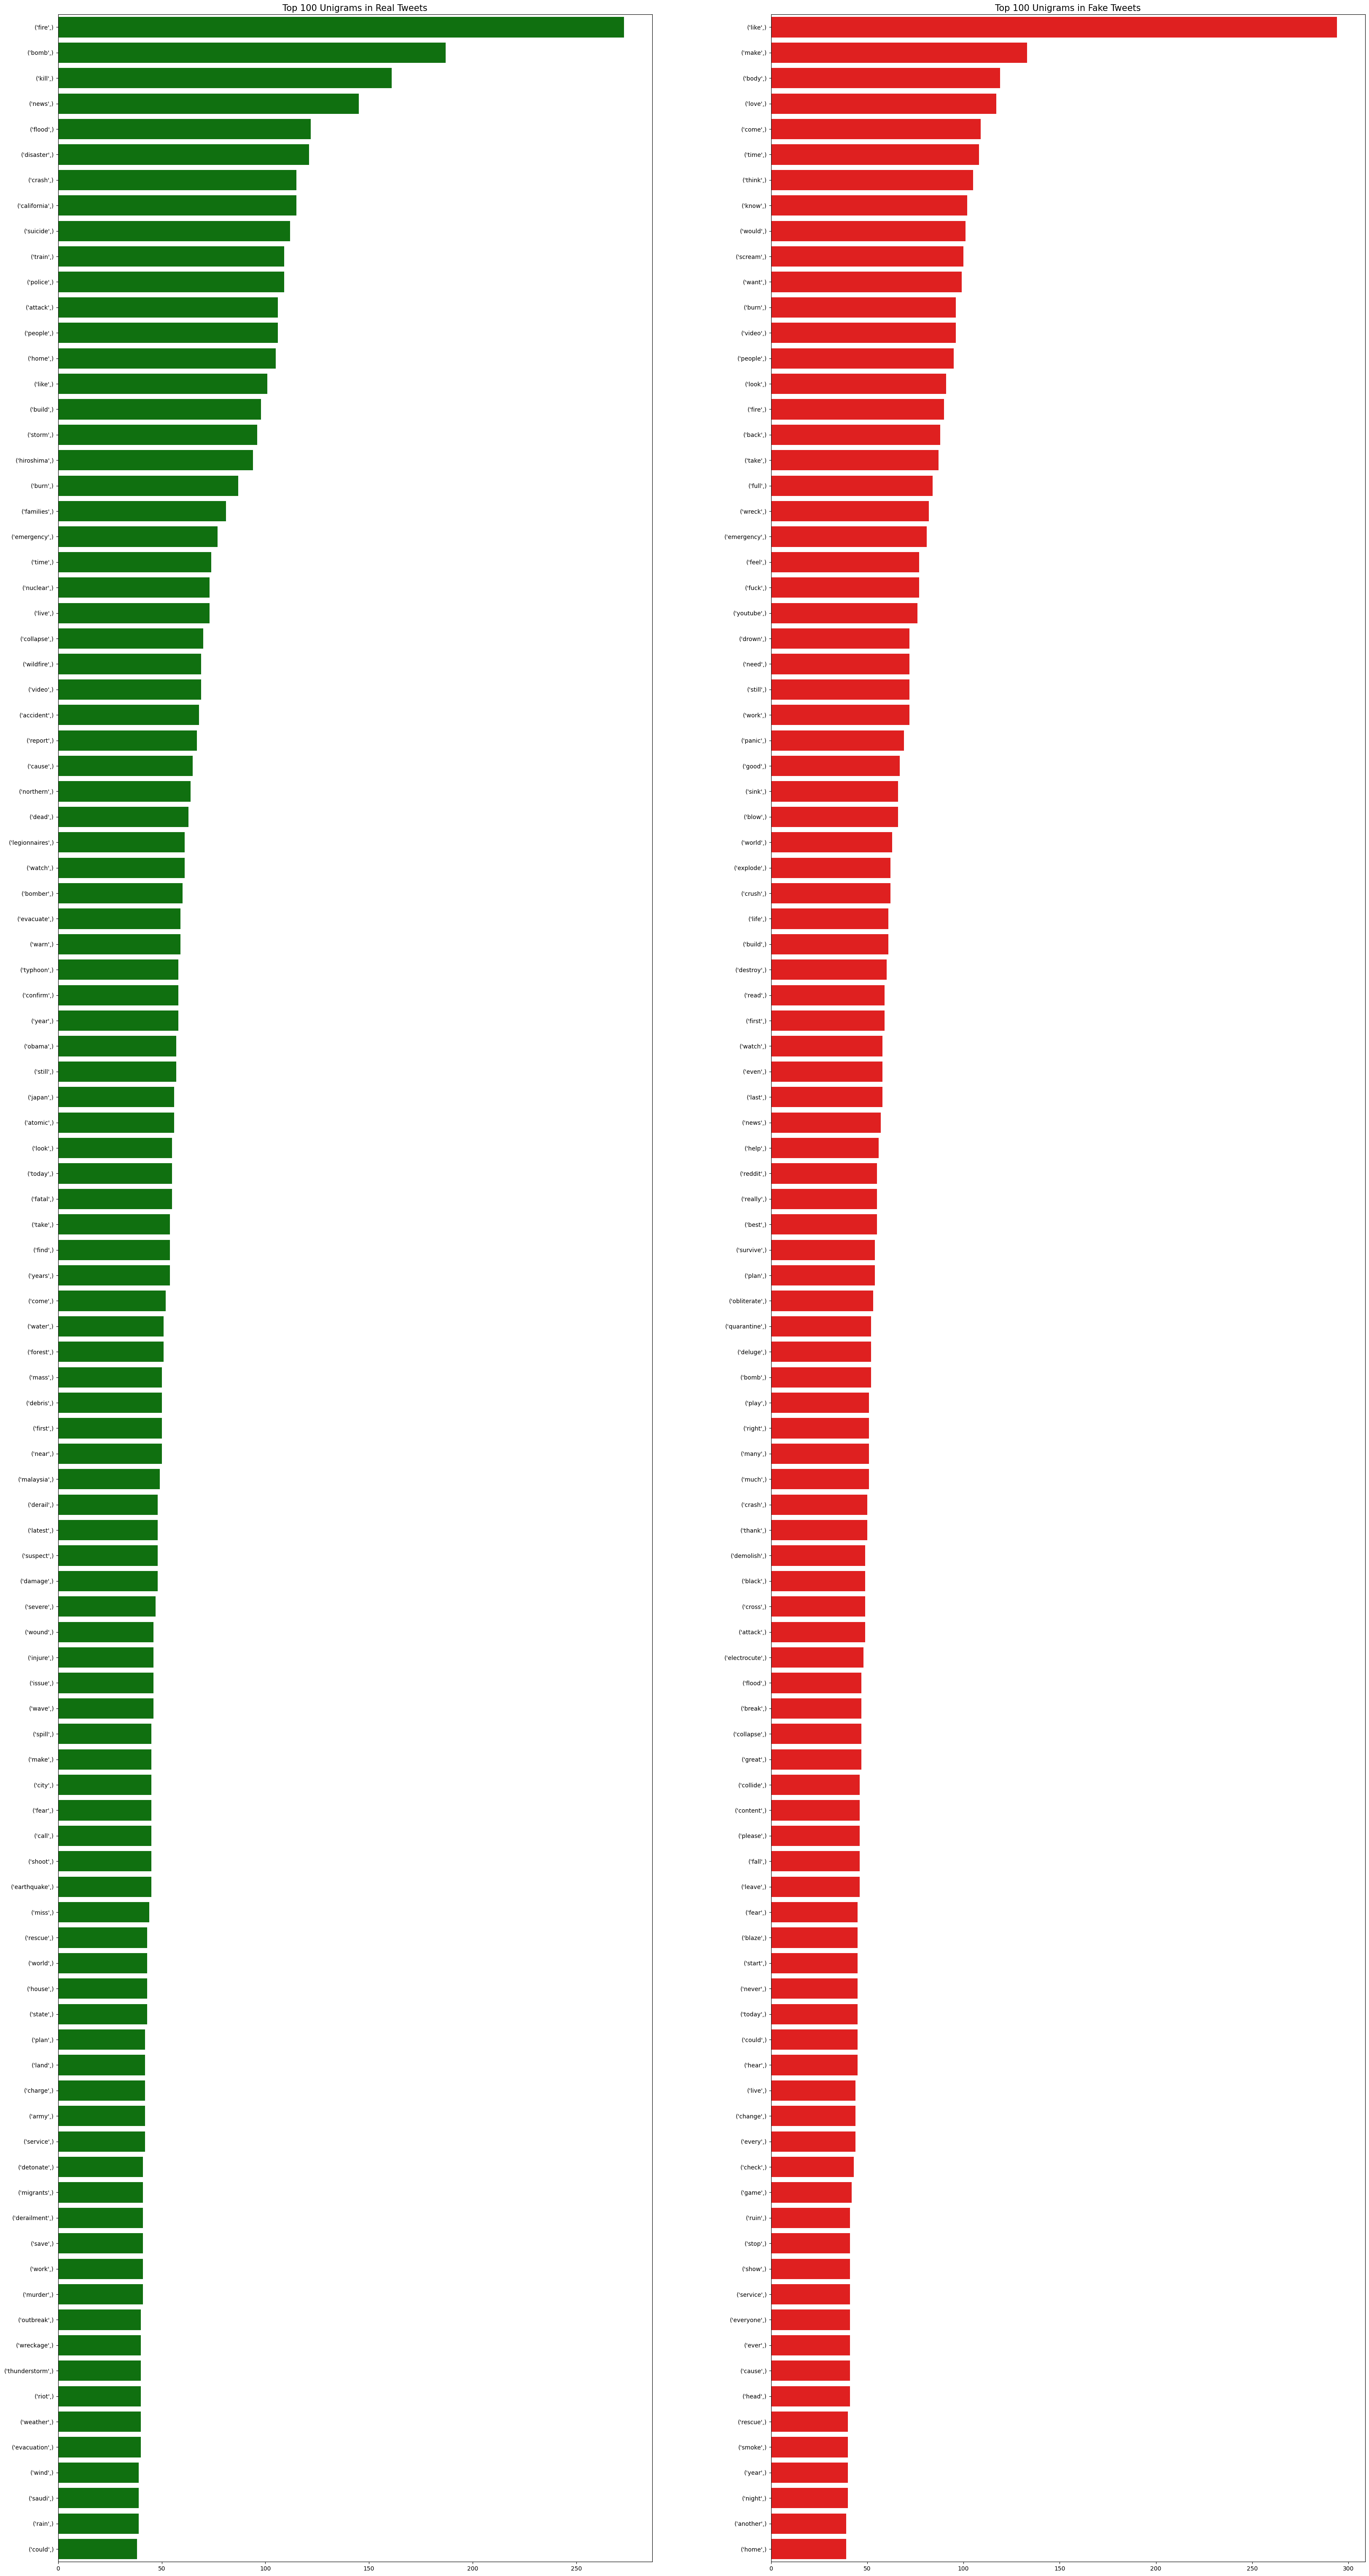

In [ ]:
# lets visualize top 100 unigrams
draw_barplots(real_unigrams,fake_unigrams," Unigrams ")

#### Bigrams

Real: (suicide,bomber),(atomic,bomber),(northern,california),(sucide,bomb),(burn,build),(california,wildfire)…

Fake: (cross,body),(youtube,video),(look,like),(full,read),(feel,like),(burn,build)…

In [ ]:
# lets create top 100 bigrams
real_bigrams = get_ngrams(real,2)
fake_bigrams = get_ngrams(fake,2)

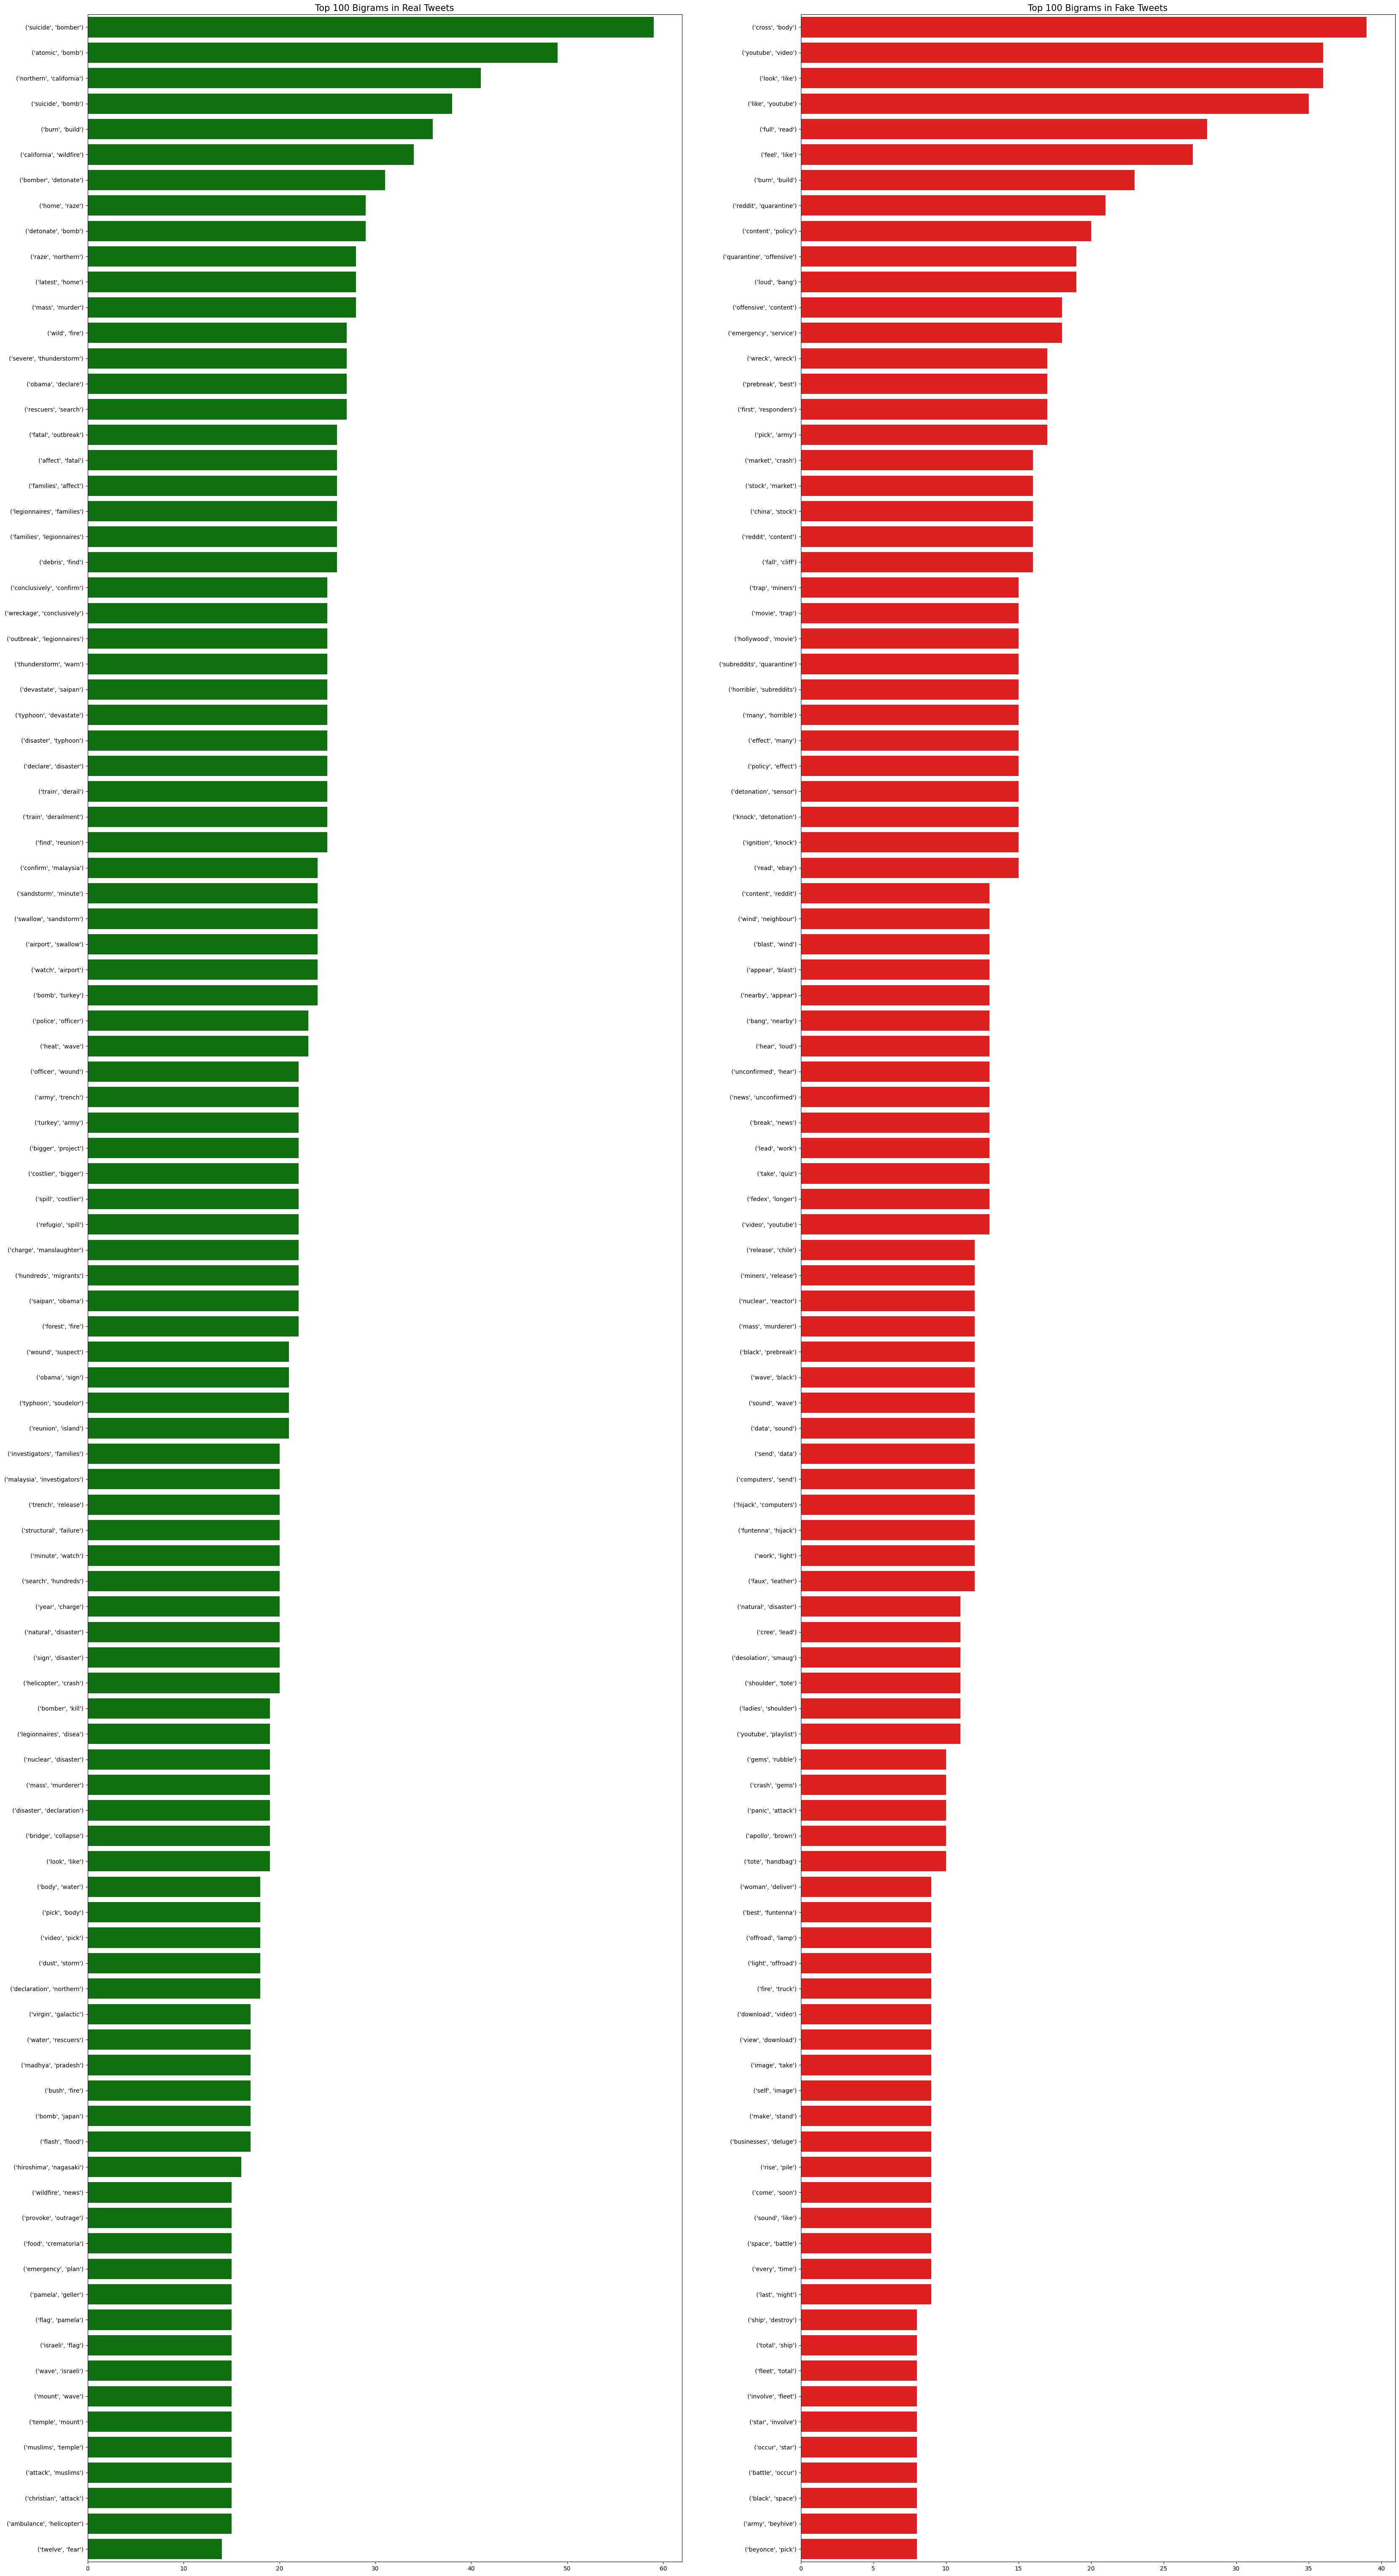

In [ ]:
# lets visualize top 100 bigrams

draw_barplots(real_bigrams,fake_bigrams," Bigrams ")

#### Trigrams

Real: (suicide, bomber,detonate),(northern, california, wildfire),(bomber, detonate, bomb),(home, raze, northern),(latest, home, raze)…

Fake: (like, youtube, video),(reddit, quarantine, offensive),(quarantine, offensive, content),(stock, market, crash),(china, stock, market)…

In [ ]:
# lets create top 100 trigrams
real_trigrams = get_ngrams(real,3)
fake_trigrams = get_ngrams(fake,3)

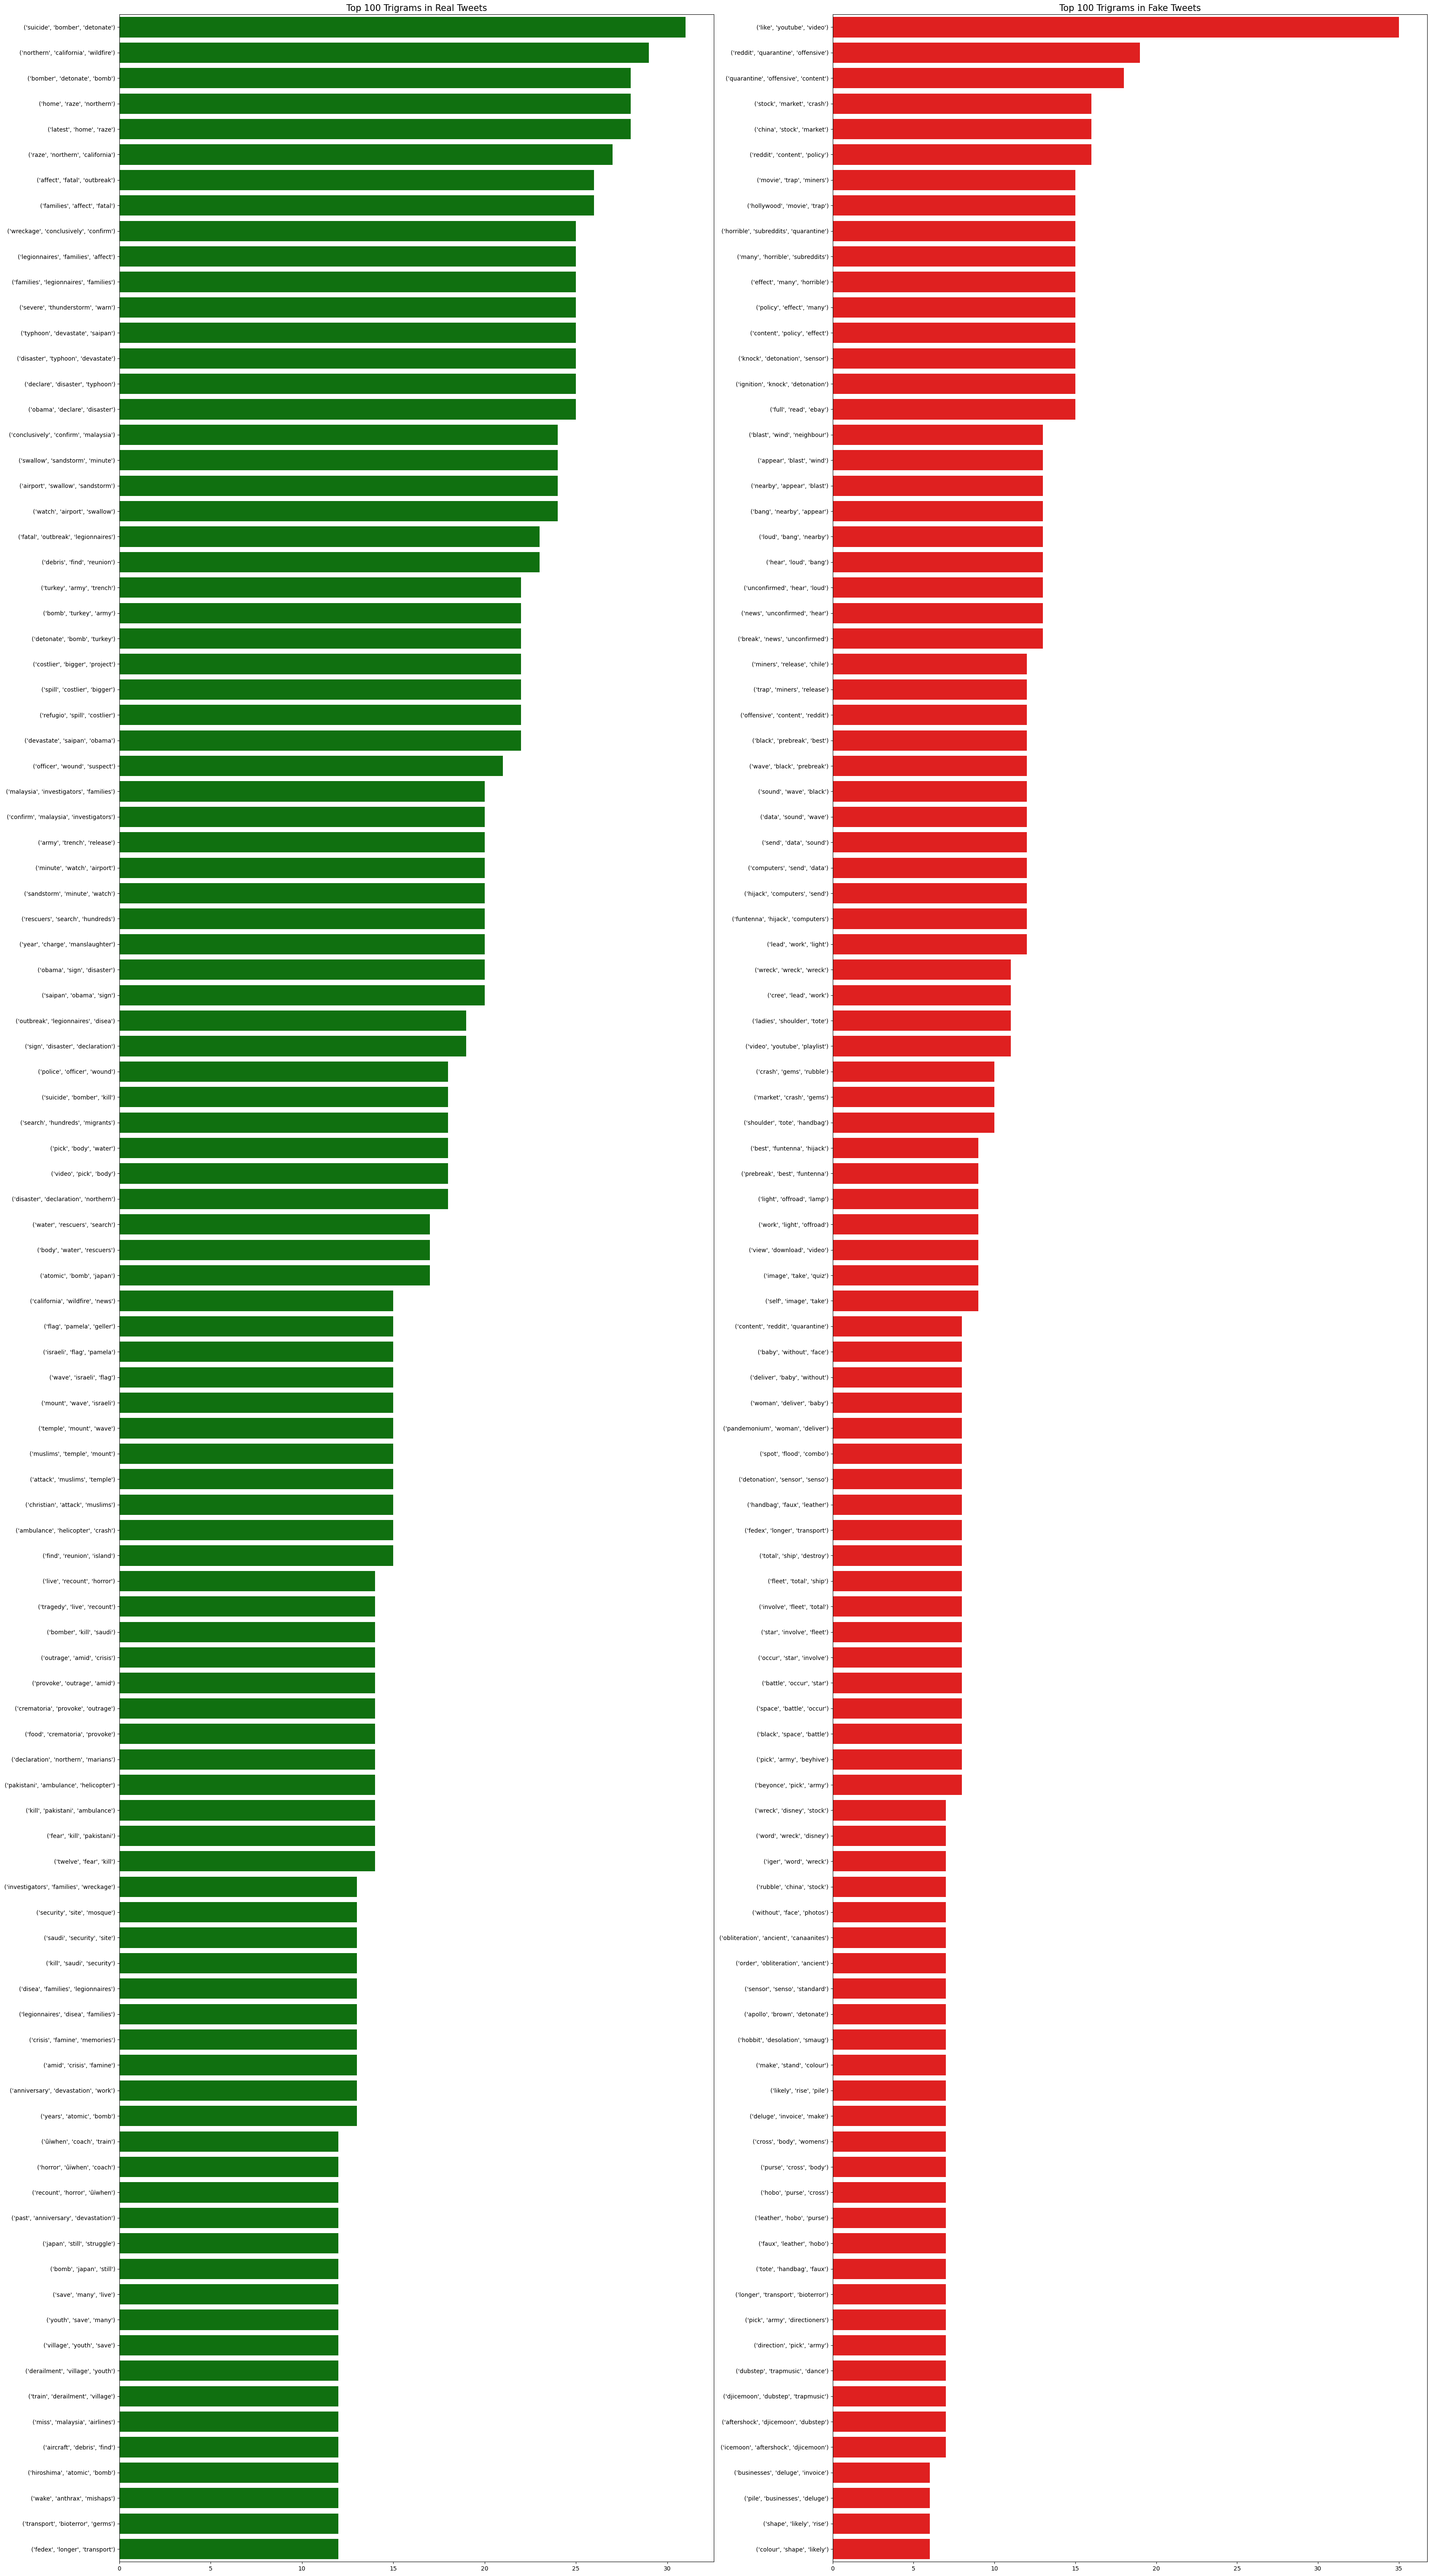

In [ ]:
# lets visualize top 100 trigrams
draw_barplots(real_trigrams,fake_trigrams," Trigrams ")

### Word Cloud
Lets plot word cloud for both real and fake tweets

In [ ]:
def word_cloud(df):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in df.text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 
        
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
        #return comment_words

    wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

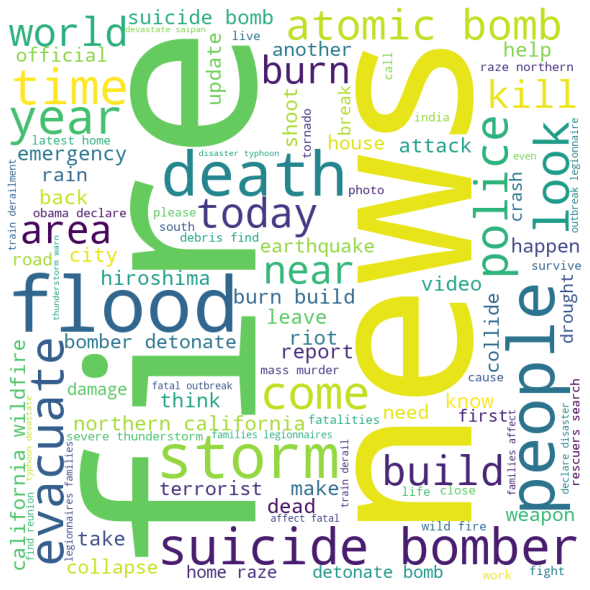

In [ ]:
# world cloud for real disaster tweets
word_cloud(real)

Above world cloud image gives a good picture of the most common words used in the real disaster tweets. Words like "news" "suicide" "bomber" "storm" "bomb" "kill" are used heavily in the real disaster tweets which makes complete sense.

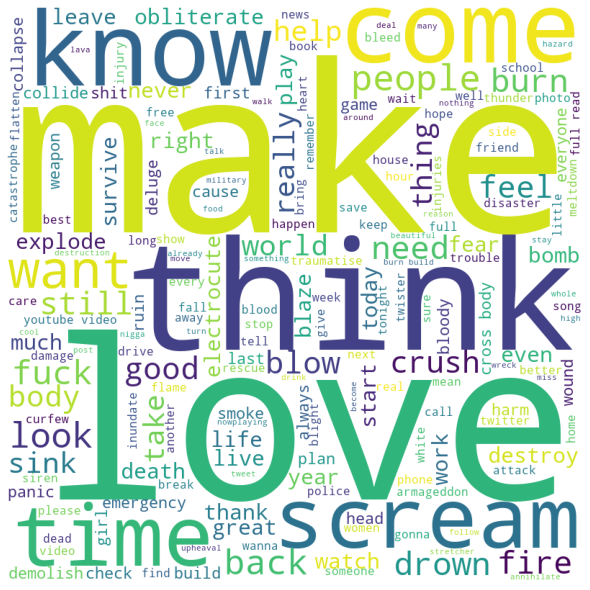

In [ ]:
# world cloud for fake disaster tweets
word_cloud(fake)

Above world cloud image gives a good picture of the most common words used in the fake disaster tweets, we can clearly notice words like "love" "know" "good" etc. are not really likely to be included real disaster tweets.

# Model Building & Evaluation

In this section we will define a few functions that will be used to build and evaluate our models. 

In [ ]:
# train validation split
tweets = train['text']
targets = train['target']
train_tweets , val_tweets , train_targets, val_targets = train_test_split(tweets.to_numpy(), 
                                                                          targets.to_numpy(), 
                                                                          test_size=0.3, random_state=42)

We define a model to automatically save the best model in the training epoch with given model name.

In [ ]:
def SaveModel(model_name):
  model = tf.keras.callbacks.ModelCheckpoint(model_name, mode='auto', monitor='val_accuracy', verbose=1, save_best_only=True)
  return model

In [ ]:
# Reduce the learning rate if the validation accuracy is not improving for 3 consecutive training epochs. 
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, verbose=1, mode='auto', min_lr=0.0001)

The following cells are used to load the pretrained text embedding model from tensorflow hub. We will use Universal Sentence Encoder and Wiki-words-500 to compare the performance since these two pretrained models have different model structures. 

In [ ]:
model_hub_path = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = hub.KerasLayer(model_hub_path,
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights. 
                                        name="USE")

In [ ]:
model_hub_path = "https://tfhub.dev/google/Wiki-words-500/2"
wiki_layer = hub.KerasLayer(model_hub_path,
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the wiki layer
                                        trainable=False, # keep the pretrained weights. 
                                        name="wiki")

The following cells define a few functions to build various CNN model(1 convolution layer or 3 convolution layers) with pretrained text embedding layers. Each function take only one argument to specify the kernel size of the convolution layer which is "n-gram".

A standard model for document classiﬁcation is to use an Embedding layer(use/wiki) as input, followed by a one-dimensional convolutional neural network, pooling layer, a dropout layer, a flatten layer, 1 dense layers and then a prediction output layer. The kernel size in the convolutional layer deﬁnes the number of words to consider as the convolution is passed across the input text document, providing a grouping parameter.

In each of following sections (1-layer CNN and 3-layer CNN), we compared the performance of models with 4 different kernel sizes (16, 8, 4, 2) representing 4 differet n-gram. 

In [ ]:
def build_1_layer_cnn_use(n_gram):
  # define the model

  model = Sequential()

  model.add(use_layer)
  model.add(tf.keras.layers.Reshape((512,1))) # for universal sentence encoder


  model.add(Conv1D(filters=128, kernel_size=n_gram, activation='relu')) 
  model.add(MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  return model



In [ ]:
def build_3_layer_cnn_use(n_gram): 
  # define the model

  model = Sequential()

  model.add(use_layer)
  model.add(tf.keras.layers.Reshape((512,1))) # for universal sentence encoder

  model.add(Conv1D(filters=128, kernel_size=n_gram, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(Conv1D(filters=64, kernel_size=n_gram, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(Conv1D(filters=32, kernel_size=n_gram, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  
  return model



In [ ]:
def build_3_layer_cnn_wiki(n_gram): 
  # define the model

  model = Sequential()

  model.add(wiki_layer)
  model.add(tf.keras.layers.Reshape((500,1))) # for universal sentence encoder

  model.add(Conv1D(filters=128, kernel_size=n_gram, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(Conv1D(filters=64, kernel_size=n_gram, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(Conv1D(filters=32, kernel_size=n_gram, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  
  return model



In [ ]:
def build_1_layer_cnn_wiki(n_gram):
  # define the model

  model = Sequential()

  model.add(wiki_layer)
  model.add(tf.keras.layers.Reshape((500,1))) # for wiki-word-500


  model.add(Conv1D(filters=128, kernel_size=n_gram, activation='relu')) 
  model.add(MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  return model



After we define how to build a model, we define another function to plot the loss and accuracy curves for the training set and the validation set. 

In [ ]:
#prints loss and accuracy curves. You can indicate first epoch to plot. 
def plot_loss_acc(history, firstepoch=0):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  acc = acc[firstepoch:]
  val_acc = history.history['val_accuracy']
    
  val_acc = val_acc[firstepoch:]
  loss = history.history['loss']
  loss=loss[firstepoch:]
  val_loss = history.history['val_loss']
  val_loss = val_loss[firstepoch:]

  epochs = range(len(acc))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  #plt.figure()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()


  plt.show()



# 1-layer CNN with Universal sentence encoder

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
use_1_16 = build_1_layer_cnn_use(16)
use_1_8 = build_1_layer_cnn_use(8)
use_1_4 = build_1_layer_cnn_use(4)
use_1_2 = build_1_layer_cnn_use(2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape_1 (Reshape)         (None, 512, 1)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 128)          2176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 248, 128)          0         
                                                                 
 flatten_1 (Flatten)         (None, 31744)             0         
                                                      

In [ ]:
use_1_16_his = use_1_16.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_1_16.h5'), ReduceLR], verbose=0)
use_1_8_his = use_1_8.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_1_8.h5'), ReduceLR], verbose=0)
use_1_4_his = use_1_4.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_1_4.h5'), ReduceLR], verbose=0)
use_1_2_his = use_1_2.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_1_2.h5'), ReduceLR], verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.80954, saving model to use_1_16.h5

Epoch 2: val_accuracy did not improve from 0.80954

Epoch 3: val_accuracy did not improve from 0.80954

Epoch 4: val_accuracy improved from 0.80954 to 0.81655, saving model to use_1_16.h5

Epoch 5: val_accuracy did not improve from 0.81655

Epoch 6: val_accuracy did not improve from 0.81655

Epoch 7: val_accuracy did not improve from 0.81655

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 8: val_accuracy did not improve from 0.81655

Epoch 9: val_accuracy did not improve from 0.81655

Epoch 10: val_accuracy did not improve from 0.81655

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 11: val_accuracy did not improve from 0.81655

Epoch 12: val_accuracy did not improve from 0.81655

Epoch 13: val_accuracy did not improve from 0.81655

Epoch 14: val_accuracy did not improve from 0.81655

Epoch 15: val_accuracy did not improve from 0.81655

Epoch 16:

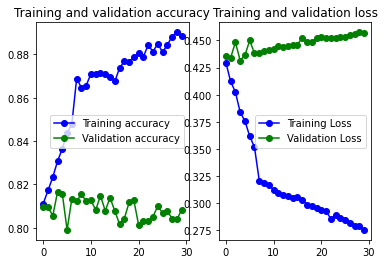

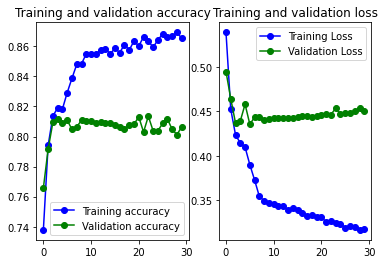

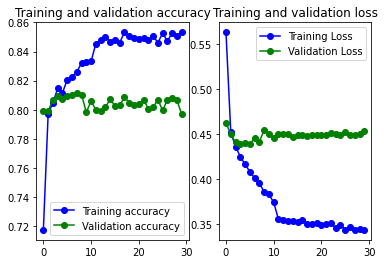

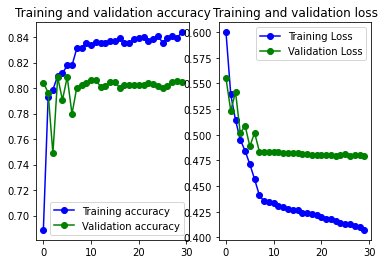

In [ ]:
plot_loss_acc(use_1_16_his)
plot_loss_acc(use_1_8_his)
plot_loss_acc(use_1_4_his)
plot_loss_acc(use_1_2_his)

In [ ]:
#Load the best model stored
bestModel = tf.keras.models.load_model('use_1_8.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
#Transform each test tweet and check the result
testweets = test.apply(lambda row : preprocess(row['text']), axis=1)
testweets = test ['text'].apply(lambda s : remove_emoji(s))
testweets[350]

'westmdcountypa land bank target first latrobe build property acquisition fight blight '

In [ ]:
#results = bestModel.predict(testweets)
results = bestModel.predict(test['text'])

102/102 [==============================] - 3s 20ms/step


In [ ]:
#Create a Dataframe with the 'id' and 'target' columns
final = pd.DataFrame()
final['id'] = test['id']
final.head()
final['target'] = results
final['target'] = final['target'].apply(lambda x:1 if x>0.5 else 0)
final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
#file to submit
final.to_csv('./use_1_8.csv', index=False)

# 1-layer CNN with Wiki-words-500

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
wiki_1_16 = build_1_layer_cnn_wiki(16)
wiki_1_8 = build_1_layer_cnn_wiki(8)
wiki_1_4 = build_1_layer_cnn_wiki(4)
wiki_1_2 = build_1_layer_cnn_wiki(2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wiki (KerasLayer)           (None, 500)               504687500 
                                                                 
 reshape_9 (Reshape)         (None, 500, 1)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 485, 128)          2176      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 242, 128)         0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 242, 128)          0         
                                                                 
 flatten_9 (Flatten)         (None, 30976)             0         
                                                      

In [ ]:
wiki_1_16_his = wiki_1_16.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_1_16.h5'), ReduceLR], verbose=0)
wiki_1_8_his = wiki_1_8.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_1_8.h5'), ReduceLR], verbose=0)
wiki_1_4_his = wiki_1_4.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_1_4.h5'), ReduceLR], verbose=0)
wiki_1_2_his = wiki_1_2.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_1_2.h5'), ReduceLR], verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.78196, saving model to wiki_1_16.h5

Epoch 2: val_accuracy improved from 0.78196 to 0.78897, saving model to wiki_1_16.h5

Epoch 3: val_accuracy did not improve from 0.78897

Epoch 4: val_accuracy improved from 0.78897 to 0.79641, saving model to wiki_1_16.h5

Epoch 5: val_accuracy did not improve from 0.79641

Epoch 6: val_accuracy improved from 0.79641 to 0.79860, saving model to wiki_1_16.h5

Epoch 7: val_accuracy did not improve from 0.79860

Epoch 8: val_accuracy did not improve from 0.79860

Epoch 9: val_accuracy did not improve from 0.79860

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 10: val_accuracy improved from 0.79860 to 0.79947, saving model to wiki_1_16.h5

Epoch 11: val_accuracy improved from 0.79947 to 0.80123, saving model to wiki_1_16.h5

Epoch 12: val_accuracy improved from 0.80123 to 0.80342, saving model to wiki_1_16.h5

Epoch 13: val_accuracy did not improve from 0.80342

Epoch 

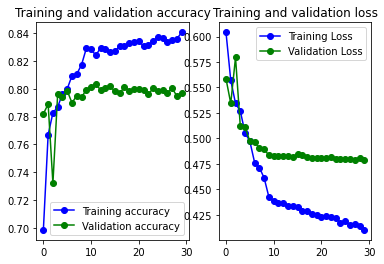

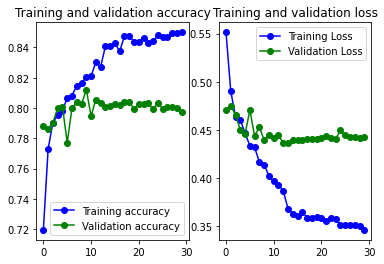

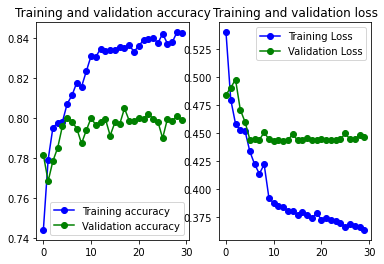

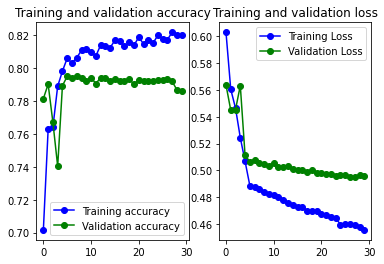

In [ ]:
plot_loss_acc(wiki_1_16_his)
plot_loss_acc(wiki_1_8_his)
plot_loss_acc(wiki_1_4_his)
plot_loss_acc(wiki_1_2_his)

In [ ]:
#Load the best model stored
bestModel = tf.keras.models.load_model('wiki_1_8.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
#Transform each test tweet and check the result
testweets = test.apply(lambda row : preprocess(row['text']), axis=1)
testweets = test ['text'].apply(lambda s : remove_emoji(s))
testweets[350]

'westmdcountypa land bank target first latrobe build property acquisition fight blight '

In [ ]:
#results = bestModel.predict(testweets)
results = bestModel.predict(test['text'])

102/102 [==============================] - 2s 11ms/step


In [ ]:
#Create a Dataframe with the 'id' and 'target' columns
final = pd.DataFrame()
final['id'] = test['id']
final.head()
final['target'] = results
final['target'] = final['target'].apply(lambda x:1 if x>0.5 else 0)
final.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
#file to submit
final.to_csv('./wiki_1_8.csv', index=False)

# 3-layer CNN with Universal sentence encoder

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
use_3_16 = build_3_layer_cnn_use(16)
use_3_8 = build_3_layer_cnn_use(8)
use_3_4 = build_3_layer_cnn_use(4)
use_3_2 = build_3_layer_cnn_use(2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape (Reshape)           (None, 512, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 497, 128)          2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 248, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 233, 64)           131136    
                                                        

In [ ]:
use_3_16_his = use_3_16.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_3_16.h5'), ReduceLR], verbose=0)
use_3_8_his = use_3_8.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_3_8.h5'), ReduceLR], verbose=0)
use_3_4_his = use_3_4.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_3_4.h5'), ReduceLR], verbose=0)
use_3_2_his = use_3_2.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('use_3_2.h5'), ReduceLR], verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.71322, saving model to use_3_16.h5

Epoch 2: val_accuracy improved from 0.71322 to 0.75438, saving model to use_3_16.h5

Epoch 3: val_accuracy improved from 0.75438 to 0.76445, saving model to use_3_16.h5

Epoch 4: val_accuracy did not improve from 0.76445

Epoch 5: val_accuracy improved from 0.76445 to 0.77102, saving model to use_3_16.h5

Epoch 6: val_accuracy improved from 0.77102 to 0.79553, saving model to use_3_16.h5

Epoch 7: val_accuracy did not improve from 0.79553

Epoch 8: val_accuracy improved from 0.79553 to 0.80385, saving model to use_3_16.h5

Epoch 9: val_accuracy did not improve from 0.80385

Epoch 10: val_accuracy did not improve from 0.80385

Epoch 11: val_accuracy did not improve from 0.80385

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_accuracy did not improve from 0.80385

Epoch 13: val_accuracy did not improve from 0.80385

Epoch 14: val_accuracy did not improve from 0

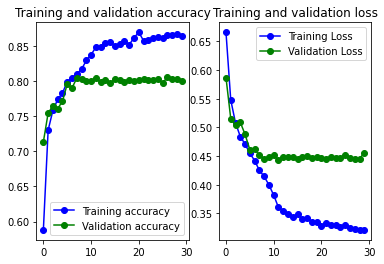

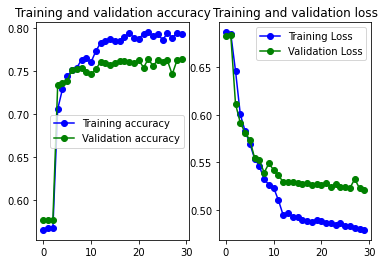

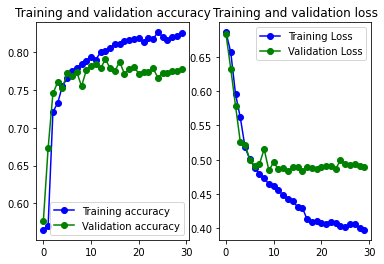

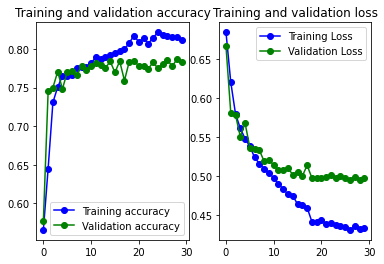

In [ ]:
plot_loss_acc(use_3_16_his)
plot_loss_acc(use_3_8_his)
plot_loss_acc(use_3_4_his)
plot_loss_acc(use_3_2_his)

In [ ]:
#Load the best model stored
bestModel = tf.keras.models.load_model('use_3_16.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
#Transform each test tweet and check the result
testweets = test.apply(lambda row : preprocess(row['text']), axis=1)
testweets = test ['text'].apply(lambda s : remove_emoji(s))
testweets[350]

'westmdcountypa land bank target first latrobe build property acquisition fight blight '

In [ ]:
#results = bestModel.predict(testweets)
results = bestModel.predict(test['text'])

102/102 [==============================] - 3s 20ms/step


In [ ]:
#Create a Dataframe with the 'id' and 'target' columns
final = pd.DataFrame()
final['id'] = test['id']
final.head()
final['target'] = results
final['target'] = final['target'].apply(lambda x:1 if x>0.5 else 0)
final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
#file to submit
final.to_csv('./use_3_16.csv', index=False)

# 3-layer CNN with Wiki-words-500

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
wiki_3_16 = build_3_layer_cnn_wiki(16)
wiki_3_8 = build_3_layer_cnn_wiki(8)
wiki_3_4 = build_3_layer_cnn_wiki(4)
wiki_3_2 = build_3_layer_cnn_wiki(2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wiki (KerasLayer)           (None, 500)               504687500 
                                                                 
 reshape_4 (Reshape)         (None, 500, 1)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 485, 128)          2176      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 242, 128)         0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 242, 128)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 227, 64)           131136    
                                                      

In [ ]:
wiki_3_16_his = wiki_3_16.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_3_16.h5'), ReduceLR], verbose=0)
wiki_3_8_his = wiki_3_8.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_3_8.h5'), ReduceLR], verbose=0)
wiki_3_4_his = wiki_3_4.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_3_4.h5'), ReduceLR], verbose=0)
wiki_3_2_his = wiki_3_2.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('wiki_3_2.h5'), ReduceLR], verbose=0)


Epoch 23: val_accuracy improved from 0.77758 to 0.77890, saving model to wiki_3_8.h5

Epoch 24: val_accuracy did not improve from 0.77890

Epoch 25: val_accuracy did not improve from 0.77890

Epoch 26: val_accuracy did not improve from 0.77890

Epoch 27: val_accuracy did not improve from 0.77890

Epoch 28: val_accuracy did not improve from 0.77890

Epoch 29: val_accuracy did not improve from 0.77890

Epoch 30: val_accuracy did not improve from 0.77890

Epoch 1: val_accuracy improved from -inf to 0.74781, saving model to wiki_3_4.h5

Epoch 2: val_accuracy improved from 0.74781 to 0.76664, saving model to wiki_3_4.h5

Epoch 3: val_accuracy improved from 0.76664 to 0.78021, saving model to wiki_3_4.h5

Epoch 4: val_accuracy did not improve from 0.78021

Epoch 5: val_accuracy improved from 0.78021 to 0.78065, saving model to wiki_3_4.h5

Epoch 6: val_accuracy did not improve from 0.78065

Epoch 7: val_accuracy improved from 0.78065 to 0.78590, saving model to wiki_3_4.h5

Epoch 8: val_acc

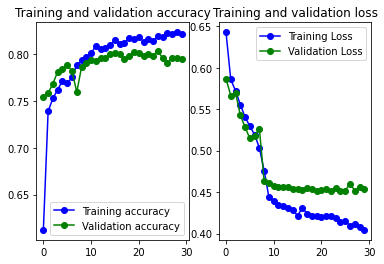

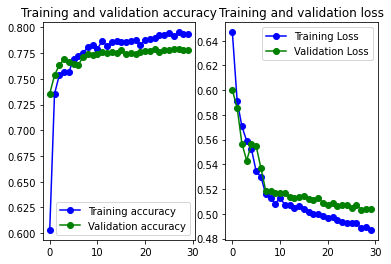

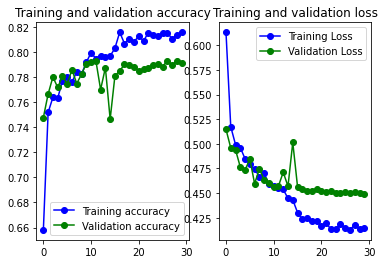

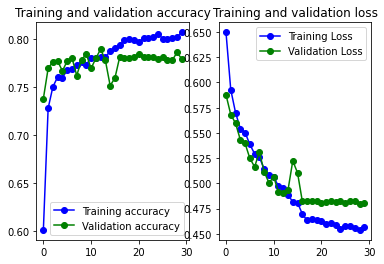

In [ ]:
plot_loss_acc(wiki_3_16_his)
plot_loss_acc(wiki_3_8_his)
plot_loss_acc(wiki_3_4_his)
plot_loss_acc(wiki_3_2_his)

In [ ]:
#Load the best model stored
bestModel = tf.keras.models.load_model('wiki_3_16.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
#Transform each test tweet and check the result
testweets = test.apply(lambda row : preprocess(row['text']), axis=1)
testweets = test ['text'].apply(lambda s : remove_emoji(s))
testweets[350]

'westmdcountypa land bank target first latrobe build property acquisition fight blight '

In [ ]:
#results = bestModel.predict(testweets)
results = bestModel.predict(test['text'])

102/102 [==============================] - 3s 20ms/step


In [ ]:
#Create a Dataframe with the 'id' and 'target' columns
final = pd.DataFrame()
final['id'] = test['id']
final.head()
final['target'] = results
final['target'] = final['target'].apply(lambda x:1 if x>0.5 else 0)
final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
#file to submit
final.to_csv('./wiki_3_16.csv', index=False)

# 3-layer CNN with Wiki-words-500 various kernel size

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = Sequential()
model.add(wiki_layer)
model.add(tf.keras.layers.Reshape((500,1))) # for wiki-word-500

model.add(Conv1D(filters=128, kernel_size=16, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.4))

model.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.4))

model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
  # compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wiki (KerasLayer)           (None, 500)               504687500 
                                                                 
 reshape (Reshape)           (None, 500, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 485, 128)          2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 242, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 242, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 235, 64)           65600     
                                                        

In [ ]:
his = model.fit(train_tweets, train_targets, epochs=30, validation_data=(val_tweets, val_targets), callbacks=[SaveModel('model.h5'), ReduceLR], verbose=0)



Epoch 1: val_accuracy improved from -inf to 0.74956, saving model to model.h5

Epoch 2: val_accuracy did not improve from 0.74956

Epoch 3: val_accuracy improved from 0.74956 to 0.77189, saving model to model.h5

Epoch 4: val_accuracy did not improve from 0.77189

Epoch 5: val_accuracy improved from 0.77189 to 0.78415, saving model to model.h5

Epoch 6: val_accuracy improved from 0.78415 to 0.78853, saving model to model.h5

Epoch 7: val_accuracy improved from 0.78853 to 0.79116, saving model to model.h5

Epoch 8: val_accuracy did not improve from 0.79116

Epoch 9: val_accuracy did not improve from 0.79116

Epoch 10: val_accuracy did not improve from 0.79116

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 11: val_accuracy improved from 0.79116 to 0.79772, saving model to model.h5

Epoch 12: val_accuracy did not improve from 0.79772

Epoch 13: val_accuracy improved from 0.79772 to 0.79816, saving model to model.h5

Epoch 14: val_accuracy did not im

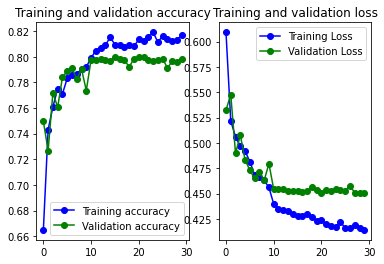

In [ ]:
plot_loss_acc(his)


In [ ]:
#Load the best model stored
bestModel = tf.keras.models.load_model('model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
#Transform each test tweet and check the result
testweets = test.apply(lambda row : preprocess(row['text']), axis=1)
testweets = test ['text'].apply(lambda s : remove_emoji(s))
testweets[350]

'westmdcountypa land bank target first latrobe build property acquisition fight blight '

In [ ]:
#results = bestModel.predict(testweets)
results = bestModel.predict(test['text'])

102/102 [==============================] - 3s 20ms/step


In [ ]:
#Create a Dataframe with the 'id' and 'target' columns
final = pd.DataFrame()
final['id'] = test['id']
final.head()
final['target'] = results
final['target'] = final['target'].apply(lambda x:1 if x>0.5 else 0)
final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
#file to submit
final.to_csv('./model.csv', index=False)

From all above models we can see that simply increasing the number of cconvolution layers(fixed or various kernel size) does not improve the model performance significantly but increase the training time.

In another word, simple CNN model with 1 convolution layer and pretrained embedding input layer, can do this real/fake tweet disaster classification job not only suffiently(in terms of accuracy and loss) but also effectively(in terms of training time). 

# 1-layer CNN Hyperparameter Tuning 

In [ ]:
def model_to_optimize(num_filters, kernel_size, pool_size, drop_rate):
    model = Sequential()
    model.add(wiki_layer)
    model.add(tf.keras.layers.Reshape((500,1)))#for wiki
    #model.add(tf.keras.layers.Reshape((512,1)))#for universal sentence encoder
    model.add(Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu'))
    model.add(MaxPooling1D(pool_size = pool_size))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(Flatten())
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

In [ ]:
params = {
    "num_filters" : [32,64,128],
    "kernel_size" : [6,8],
    "pool_size" : [2,4],
    "drop_rate" : [0.4]
}

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=model_to_optimize,
                            epochs=20,
                            verbose=True)


search = GridSearchCV(estimator=model, param_grid=params,
                              cv=5, verbose=1)
search_result = search.fit(train_tweets, train_targets)
grid = pd.DataFrame(search.cv_results_)
grid.to_csv('grid.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/20
134/134 [==============================] - 4s 20ms/step - loss: 0.6223 - accuracy: 0.6570
Epoch 2/20
134/134 [==============================] - 3s 20ms/step - loss: 0.5712 - accuracy: 0.7567
Epoch 3/20
134/134 [==============================] - 3s 19ms/step - loss: 0.5528 - accuracy: 0.7703
Epoch 4/20
134/134 [==============================] - 3s 19ms/step - loss: 0.5343 - accuracy: 0.7835
Epoch 5/20
134/134 [==============================] - 3s 19ms/step - loss: 0.5266 - accuracy: 0.7816
Epoch 6/20
134/134 [==============================] - 3s 20ms/step - loss: 0.5160 - accuracy: 0.7882
Epoch 7/20
134/134 [==============================] - 4s 33ms/step - loss: 0.5006 - accuracy: 0.7957
Epoch 8/20
134/134 [==============================] - 3s 19ms/step - loss: 0.4906 - accuracy: 0.7957
Epoch 9/20
134/134 [==============================] - 3s 19ms/step - loss: 0.4870 - accuracy: 0.7999
Epoch 10/20
134/134 [=========

AttributeError: ignored

In [ ]:
search_result.best_params_

# Multi Channel n-gram CNN Model

A multi-channel convolutional neural network in this project involves using both USE layer and wiki layer. This allows the document to be processed at diﬀerent embedding vectors at a time, whilst the model learns how to best integrate these interpretations.The output from the two channels are concatenated into a single vector and process by a Dense layer and an output layer. 

In [ ]:
model_hub_path = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = hub.KerasLayer(model_hub_path,
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights. 
                                        name="USE")

In [ ]:
model_hub_path = "https://tfhub.dev/google/Wiki-words-500/2"
wiki_layer = hub.KerasLayer(model_hub_path,
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the wiki layer
                                        trainable=False, # keep the pretrained weights. 
                                        name="wiki")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 USE_input (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 wiki_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['USE_input[0][0]']              
                                                                                                  
 wiki (KerasLayer)              (None, 500)          504687500   ['wiki_input[0][0]']             
                                                                                              

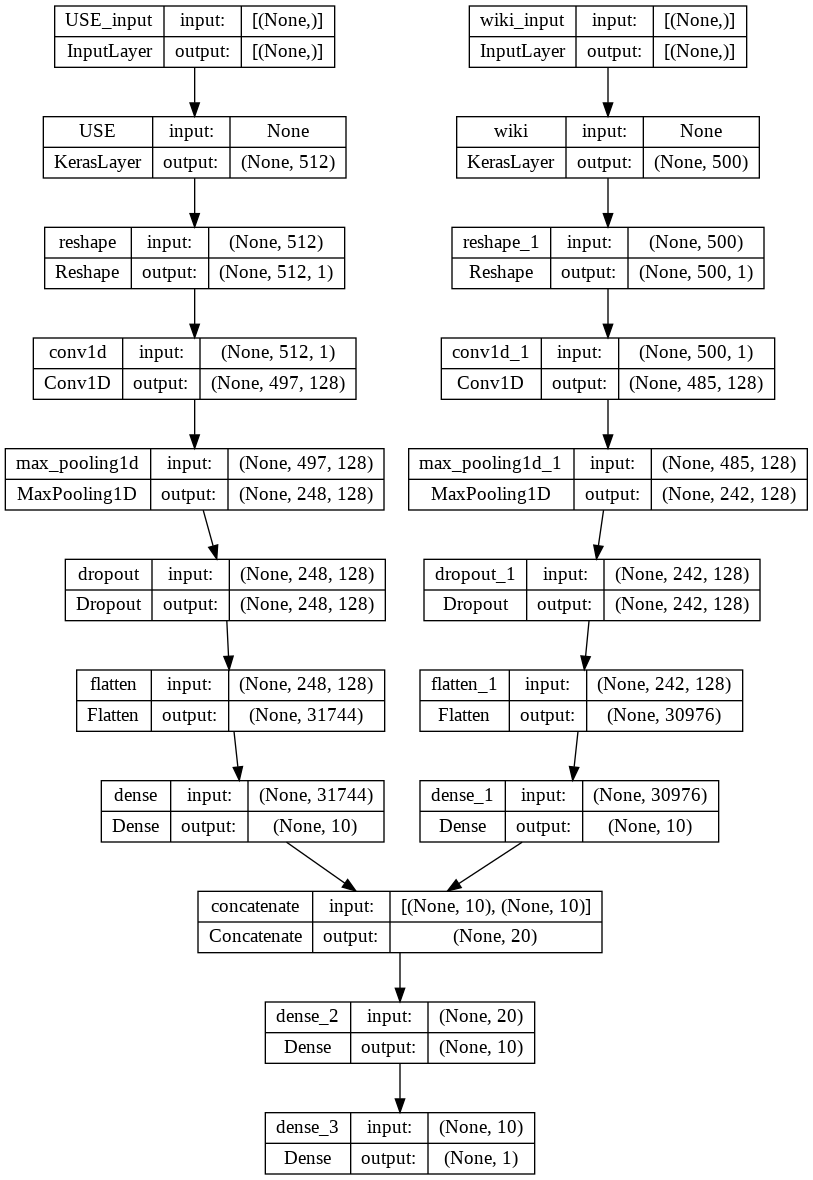

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

model1 = Sequential()
model1.add(use_layer)
#model.add(tf.keras.layers.Reshape((500,1))) #for wiki
model1.add(tf.keras.layers.Reshape((512,1))) # for universal sentence encoder
model1.add(Conv1D(filters=128, kernel_size=16, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(tf.keras.layers.Dropout(0.4))
#model1.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
#model1.add(MaxPooling1D(pool_size=2))
#model1.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
#model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(10, activation='relu'))


model2 = Sequential()
model2.add(wiki_layer)
model2.add(tf.keras.layers.Reshape((500,1))) #for wiki
#model2.add(tf.keras.layers.Reshape((512,1))) # for universal sentence encoder
model2.add(Conv1D(filters=128, kernel_size=16, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(tf.keras.layers.Dropout(0.4))
#model2.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
#model2.add(MaxPooling1D(pool_size=2))
#model2.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
#model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(10, activation='relu'))

    
    # merge 
merged = Concatenate()([model1.output, model2.output])
    # interpretation 
dense1 = Dense(10, activation='relu')(merged) 
outputs = Dense(1, activation='sigmoid')(dense1) 
multi = Model([model1.input, model2.input], outputs=outputs) 
# compile 
multi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    # summarize 
multi.summary() 
plot_model(multi, show_shapes=True) 




In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
SaveModel = tf.keras.callbacks.ModelCheckpoint('cnn.h5', 
                                           mode='auto', monitor='val_accuracy', 
                                           verbose=1, 
                                           save_best_only=True)

In [ ]:
history = multi.fit([train_tweets,train_tweets], array(train_targets), epochs=15,batch_size=16,validation_data=([val_tweets,val_tweets], val_targets), callbacks=SaveModel)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


334/334 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.7465
Epoch 1: val_accuracy improved from -inf to 0.79816, saving model to cnn.h5
334/334 [==============================] - 59s 141ms/step - loss: 0.5147 - accuracy: 0.7465 - val_loss: 0.4460 - val_accuracy: 0.7982
Epoch 2/15
334/334 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8118
Epoch 2: val_accuracy did not improve from 0.79816
334/334 [==============================] - 34s 101ms/step - loss: 0.4290 - accuracy: 0.8118 - val_loss: 0.4480 - val_accuracy: 0.7929
Epoch 3/15
334/334 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8232
Epoch 3: val_accuracy improved from 0.79816 to 0.81655, saving model to cnn.h5
334/334 [==============================] - 50s 150ms/step - loss: 0.4083 - accuracy: 0.8232 - val_loss: 0.4278 - val_accuracy: 0.8165
Epoch 4/15
334/334 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8307
Epoch 4: val_accura

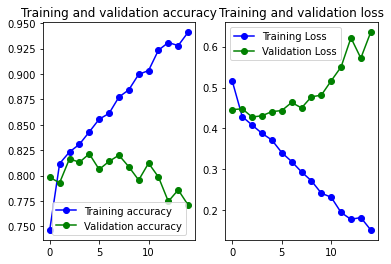

In [ ]:
plot_loss_acc(history)

In [ ]:
from keras.models import load_model

model = load_model(('cnn.h5'),custom_objects={'KerasLayer':hub.KerasLayer})


In [ ]:
results = model.predict([array(testweets),array(testweets)])

In [ ]:
#Create a Dataframe with the 'id' and 'target' columns
final = pd.DataFrame()
final['id'] = test['id']
final.head()
final['target'] = results
final['target'] = final['target'].apply(lambda x:1 if x>0.5 else 0)
final.head()

In [ ]:
#file to submit
final.to_csv('./cnn_multi_L.csv', index=False)

# BERT - The Concept
BERT is a deep learning model. It has given state-of-the-art results on a variety of NLP tasks. It stands for Bidirectional Encoder Representations from Transformers. It is based on the Transformer architecture and has been pre-trained on Wikipedia(2,500 million words) and Books Corpus(800 million words). BERT is a deeply bidirectional model. This means that BERT learns information from both the left and the right sides of a token’s context. Many people believe that BERT has significantly altered the NLP landscape. Therefore, we want to use this Kaggle competition as an opportunity to learn and practice applying BERT to an NLP task.


## Preprocessing Text for BERT

Before we feed our dataset to the BERT model, we need to preprocess the text in order to make the BERT understand them. There are totally three embeddings that are used in BERT.
Token Embeddings: For a given token, its input representation is constructed by summing the corresponding token, segment, and position embeddings.
Position Embeddings: BERT learns and uses positional embeddings to express the position of words in a sentence. 
Segment Embeddings: BERT can also take sentence pairs as inputs for tasks. 


# Code Implementation in Tensorflow 2.0

In [2]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [3]:
!pip install bert-tensorflow==1.0.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.9 MB/s 


In [4]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import bert.tokenization as tokenization

# Re-loading input files, BERTS seems to do better on raw data

In [5]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [6]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [7]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 28.4 s, sys: 6.34 s, total: 34.8 s
Wall time: 43.3 s


In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [10]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [11]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [12]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

Epoch 1/3
381/381 [==============================] - 673s 2s/step - loss: 0.4896 - accuracy: 0.7686 - val_loss: 0.3986 - val_accuracy: 0.8339
Epoch 2/3
381/381 [==============================] - 639s 2s/step - loss: 0.3426 - accuracy: 0.8585 - val_loss: 0.4037 - val_accuracy: 0.8313
Epoch 3/3
381/381 [==============================] - 639s 2s/step - loss: 0.2556 - accuracy: 0.8987 - val_loss: 0.4248 - val_accuracy: 0.8326


In [14]:
test_pred = model.predict(test_input)

102/102 [==============================] - 117s 1s/step


In [15]:
submission=pd.DataFrame()
submission['Id']=test['id']
submission['target'] = test_pred.round().astype(int)
submission.to_csv('bert.csv', index=False)
